In [2]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl

import copy
from numpy.linalg import inv
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
from statsmodels.tsa.vector_ar import vecm
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.vector_ar.vecm import *


Functions used later in the code

In [3]:
def run_tests_c(variable, summary_df):
    # ADF Test
    data = variable.dropna()
    result = adfuller(data, regression='c', maxlag= None)
    adf_statistic = round(result[0], 2)
    p_value = result[1]
    
    # Check if p-value is lower than 0.01, 0.05, or 0.1
    if p_value < 0.01:
        asterisk_adf = '***'
    elif p_value < 0.05:
        asterisk_adf = '**'
    elif p_value < 0.1:
        asterisk_adf = '*'
    else:
        asterisk_adf = ''
    
    # Check if column exists in summary_df and if not, create it
    if variable.name not in summary_df.columns:
        summary_df[variable.name] = np.nan
    
    # Add test statistics to summary_df
    summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
    
    return summary_df

def run_tests_ct(variable, summary_df):
    # ADF Test
    data = variable.dropna()
    result = adfuller(data, regression='ct', maxlag= None)
    adf_statistic = round(result[0], 2)
    p_value = result[1]
    
    # Check if p-value is lower than 0.01, 0.05, or 0.1
    if p_value < 0.01:
        asterisk_adf = '***'
    elif p_value < 0.05:
        asterisk_adf = '**'
    elif p_value < 0.1:
        asterisk_adf = '*'
    else:
        asterisk_adf = ''
    
    # Check if column exists in summary_df and if not, create it
    if variable.name not in summary_df.columns:
        summary_df[variable.name] = np.nan
    
    # Add test statistics to summary_df
    summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
    
    return summary_df

def adf_nlag(variable, reg, lag_df):
    data = variable.dropna()
    result = adfuller(data, regression=reg, maxlag= None)
    nlag= result[2]

    if variable.name not in lag_df.columns:
        lag_df[variable.name] = np.nan
    
        # Add test statistics to summary_df
        lag_df.loc['nlags', variable.name] = float(nlag)

    return lag_df

def create_industry_dfs(treated_vars, industry_names, endog_vars, exog_vars):
  """
  Creates a dictionary of DataFrames, each containing time series for an industry
  (first column) and exogenous variables concatenated on the right. DataFrame names
  follow the format "industry_df".

  Args:
      treated_vars (pandas.DataFrame): DataFrame containing time series data.
      industry_names (list): List of industry names.
      endog_vars (list): List of endogenous variable names.
      exog_vars (list): List of exogenous variable names.

  Returns:
      dict: Dictionary of DataFrames, where keys are industry names and values
            are the corresponding DataFrames.
  """

  industry_dfs = {}
  for industry in industry_names:
    # Filter treated variables for the current industry
    industry_vars = [var for var in treated_vars.columns if var.startswith(industry)]
    industry_df = treated_vars[industry_vars].copy() # Select industry columns
    industry_df = pd.concat([industry_df, treated_vars[endog_vars]], axis=1)

    #Setting the shocks to interest rate futures (called 'Futures Shock') as first variable in model such that it equates to 0 in the cholensky decomosition
    column_to_move = 'Futures Shock'
    # Create a new list of columns with the specified column at the start
    cols = [column_to_move] + [col for col in industry_df if col != column_to_move]
    # Reorder the DataFrame
    industry_df = industry_df[cols]
    #drop the column 'SPX shock'
    industry_df = industry_df.drop('SPX Shock', axis=1)
    industry_df = industry_df.dropna()  # Drop rows with missing values
    
    exog_df = treated_vars[exog_vars].copy().dropna()  # Select exogenous columns and drop rows with missing values
    common_index = industry_df.index.intersection(exog_df.index)
    industry_df = industry_df.loc[common_index]
    exog_df = exog_df.loc[common_index]


    #if len(exog_df) != len(industry_df):
        #industry_df = industry_df.iloc[-len(exog_df):]  # Truncate to match length of industry_df

    # Name the DataFrame
    industry_df.name = industry + "_df"

    industry_dfs[industry] = {"industry_df": industry_df, "exogenous_df": exog_df}

  return industry_dfs

/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_38062/1213287828.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data2 = data2.resample('M').mean()


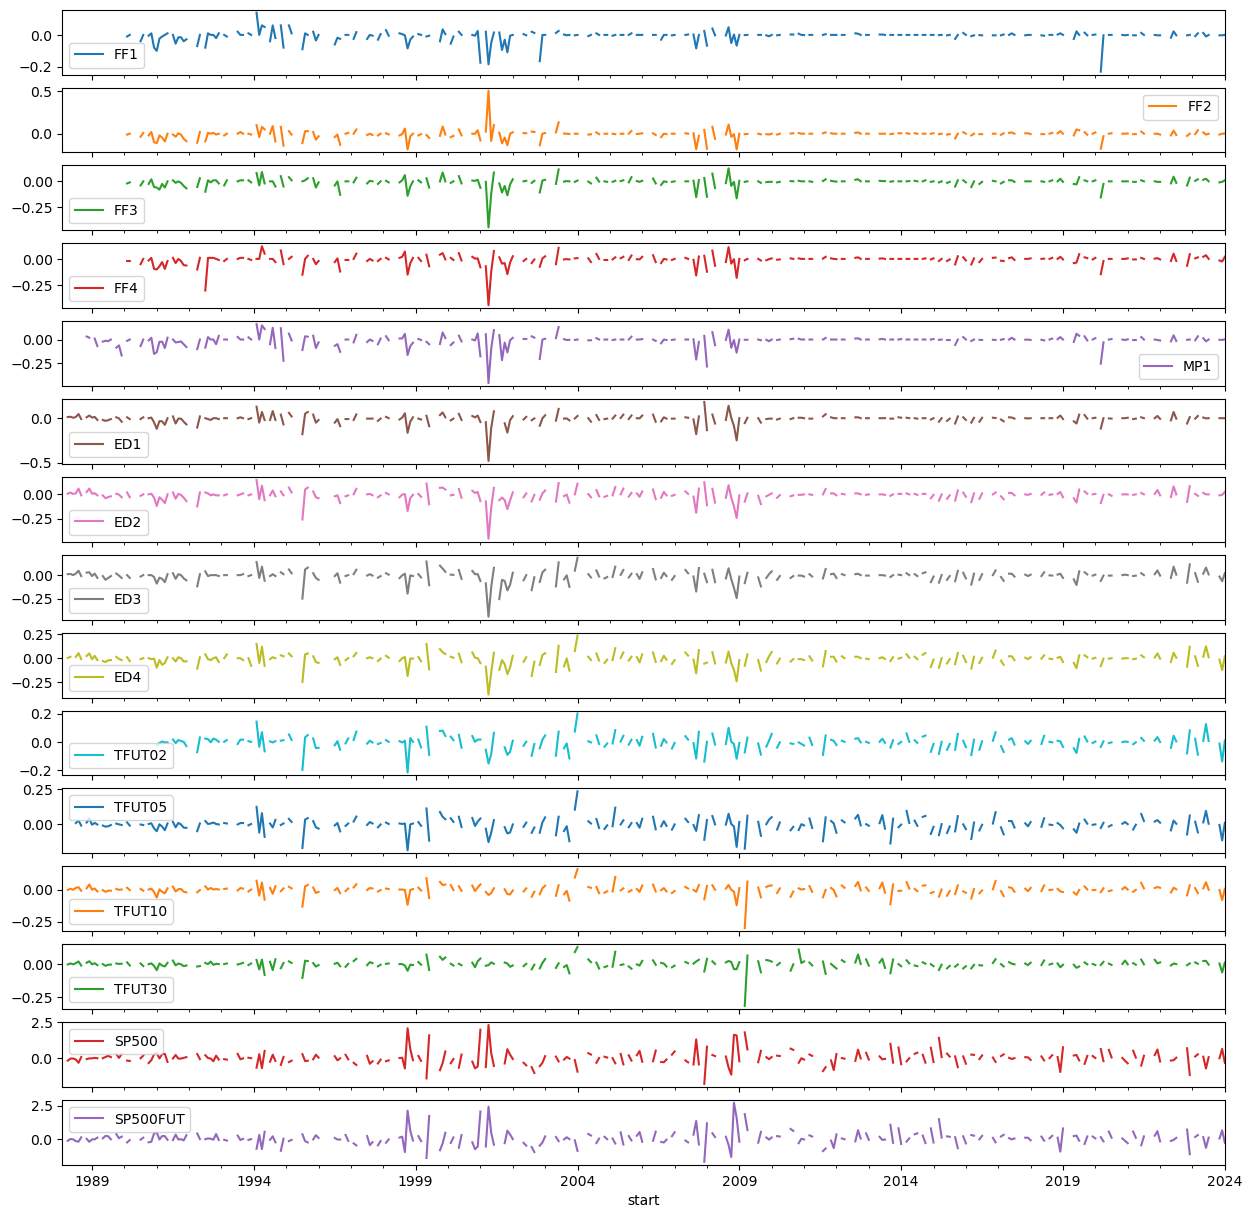

In [45]:
data2 = pd.read_excel('fomc_surprises_jk.xlsx', engine='openpyxl')

#I want to turn this into monthly data
data2['start'] = pd.to_datetime(data2['start'])
data2 = data2.set_index('start')
data2 = data2.select_dtypes(include=[np.number])  # Exclude non-numeric columns
data2 = data2.resample('M').mean()
data2

#Plot the times series
data2.plot(subplots=True, figsize=(15, 15))
plt.show()



#save as an xlsx
data2.to_excel('fomc_surprises_jk_monthly.xlsx')


In [37]:
data = pd.read_excel('Assignment 2 Data.xlsx', sheet_name='Condensed (final) data', engine='openpyxl')

#make the date the index
data.set_index('Date', inplace=True)
data['PCEPI'] = data['PCEPI'] /100 # Make the inflation index with base 1 instead of 100
industries = data.iloc[:,6:-2].columns
industry_names = industries.tolist()
nominal_vars = data[industry_names + ['GDP' , 'M2SL']]

real_vars = pd.DataFrame()

for var in nominal_vars.columns:
    real_vars[var] = nominal_vars[var] / data['PCEPI']

data2

start                                        description  \
0   1988-02-04 11:30:00                    FOMC Announcement (Unscheduled)   
1   1988-02-05 11:30:00                    FOMC Announcement (Unscheduled)   
2   1988-02-11 11:30:00                      FOMC Announcement (Scheduled)   
3   1988-04-04 11:30:00                    FOMC Announcement (Unscheduled)   
4   1988-04-05 11:30:00                    FOMC Announcement (Unscheduled)   
..                  ...                                                ...   
354 2023-07-26 14:00:00  FOMC Rate Decision FDTR surv 5.50% act 5.50% p...   
355 2023-09-20 14:00:00  FOMC Rate Decision FDTR surv 5.50% act 5.50% p...   
356 2023-11-01 14:00:00  FOMC Rate Decision FDTR surv 5.50% act 5.50% p...   
357 2023-12-13 14:00:00  FOMC Rate Decision FDTR surv 5.50% act 5.50% p...   
358 2024-01-31 14:00:00  FOMC Rate Decision FDTR surv 5.50% act 5.50% p...   

        FF1     FF2    FF3     FF4      MP1   ED1    ED2     ED3    ED4  \
0       NaN     NaN    NaN     NaN      NaN -0.02 -0.020 -0.0200 -0.010   
1       NaN     NaN    NaN     NaN      NaN  0.02  0.010  0.0100  0.010   
2       NaN     NaN    NaN     NaN      NaN  0.01  0.000 -0.0100 -0.020   
3       NaN     NaN    NaN     NaN      NaN  0.02  0.010  0.0100  0.010   
4       NaN     NaN    NaN     NaN      NaN  0.03  0.030  0.0400  0.030   
..      ...     ...    ...     ...      ...   ...    ...     ...    ...   
354  0.0000  0.0000  0.000  0.0000  0.00000  0.00  0.000  0.0075  0.010   
355 -0.0025 -0.0050  0.025  0.0275 -0.00750  0.01  0.035  0.0650  0.095   
356 -0.0025 -0.0100 -0.010 -0.0150 -0.00259  0.00 -0.010 -0.0150 -0.015   
357 -0.0025  0.0000 -0.005 -0.0250 -0.00431  0.00 -0.005 -0.0650 -0.125   
358  0.0000  0.0025  0.010  0.0200  0.00250  0.00  0.025  0.0200  0.020   

      TFUT02   TFUT05   TFUT10   TFUT30    SP500  SP500FUT  
0        NaN      NaN -0.00910 -0.00333  0.11527   0.25766  
1        NaN      NaN  0.00449  0.00326 -0.16188  -0.19681  
2        NaN      NaN  0.00452  0.00331 -0.04682  -0.11685  
3        NaN      NaN -0.00473 -0.00719 -0.23604  -0.25109  
4        NaN      NaN  0.00945  0.00717 -0.06204   0.00000  
..       ...      ...      ...      ...      ...       ...  
354  0.00603  0.00165 -0.00179 -0.00387  0.08908   0.08179  
355  0.06841  0.05526  0.03491  0.01460 -0.17053  -0.18928  
356 -0.01208 -0.00676 -0.00378  0.00460  0.01259   0.01773  
357 -0.13941 -0.11671 -0.08280 -0.06331  0.66225   0.63107  
358  0.00992  0.00815  0.00534  0.01205 -0.30595  -0.30568  

[359 rows x 17 columns]

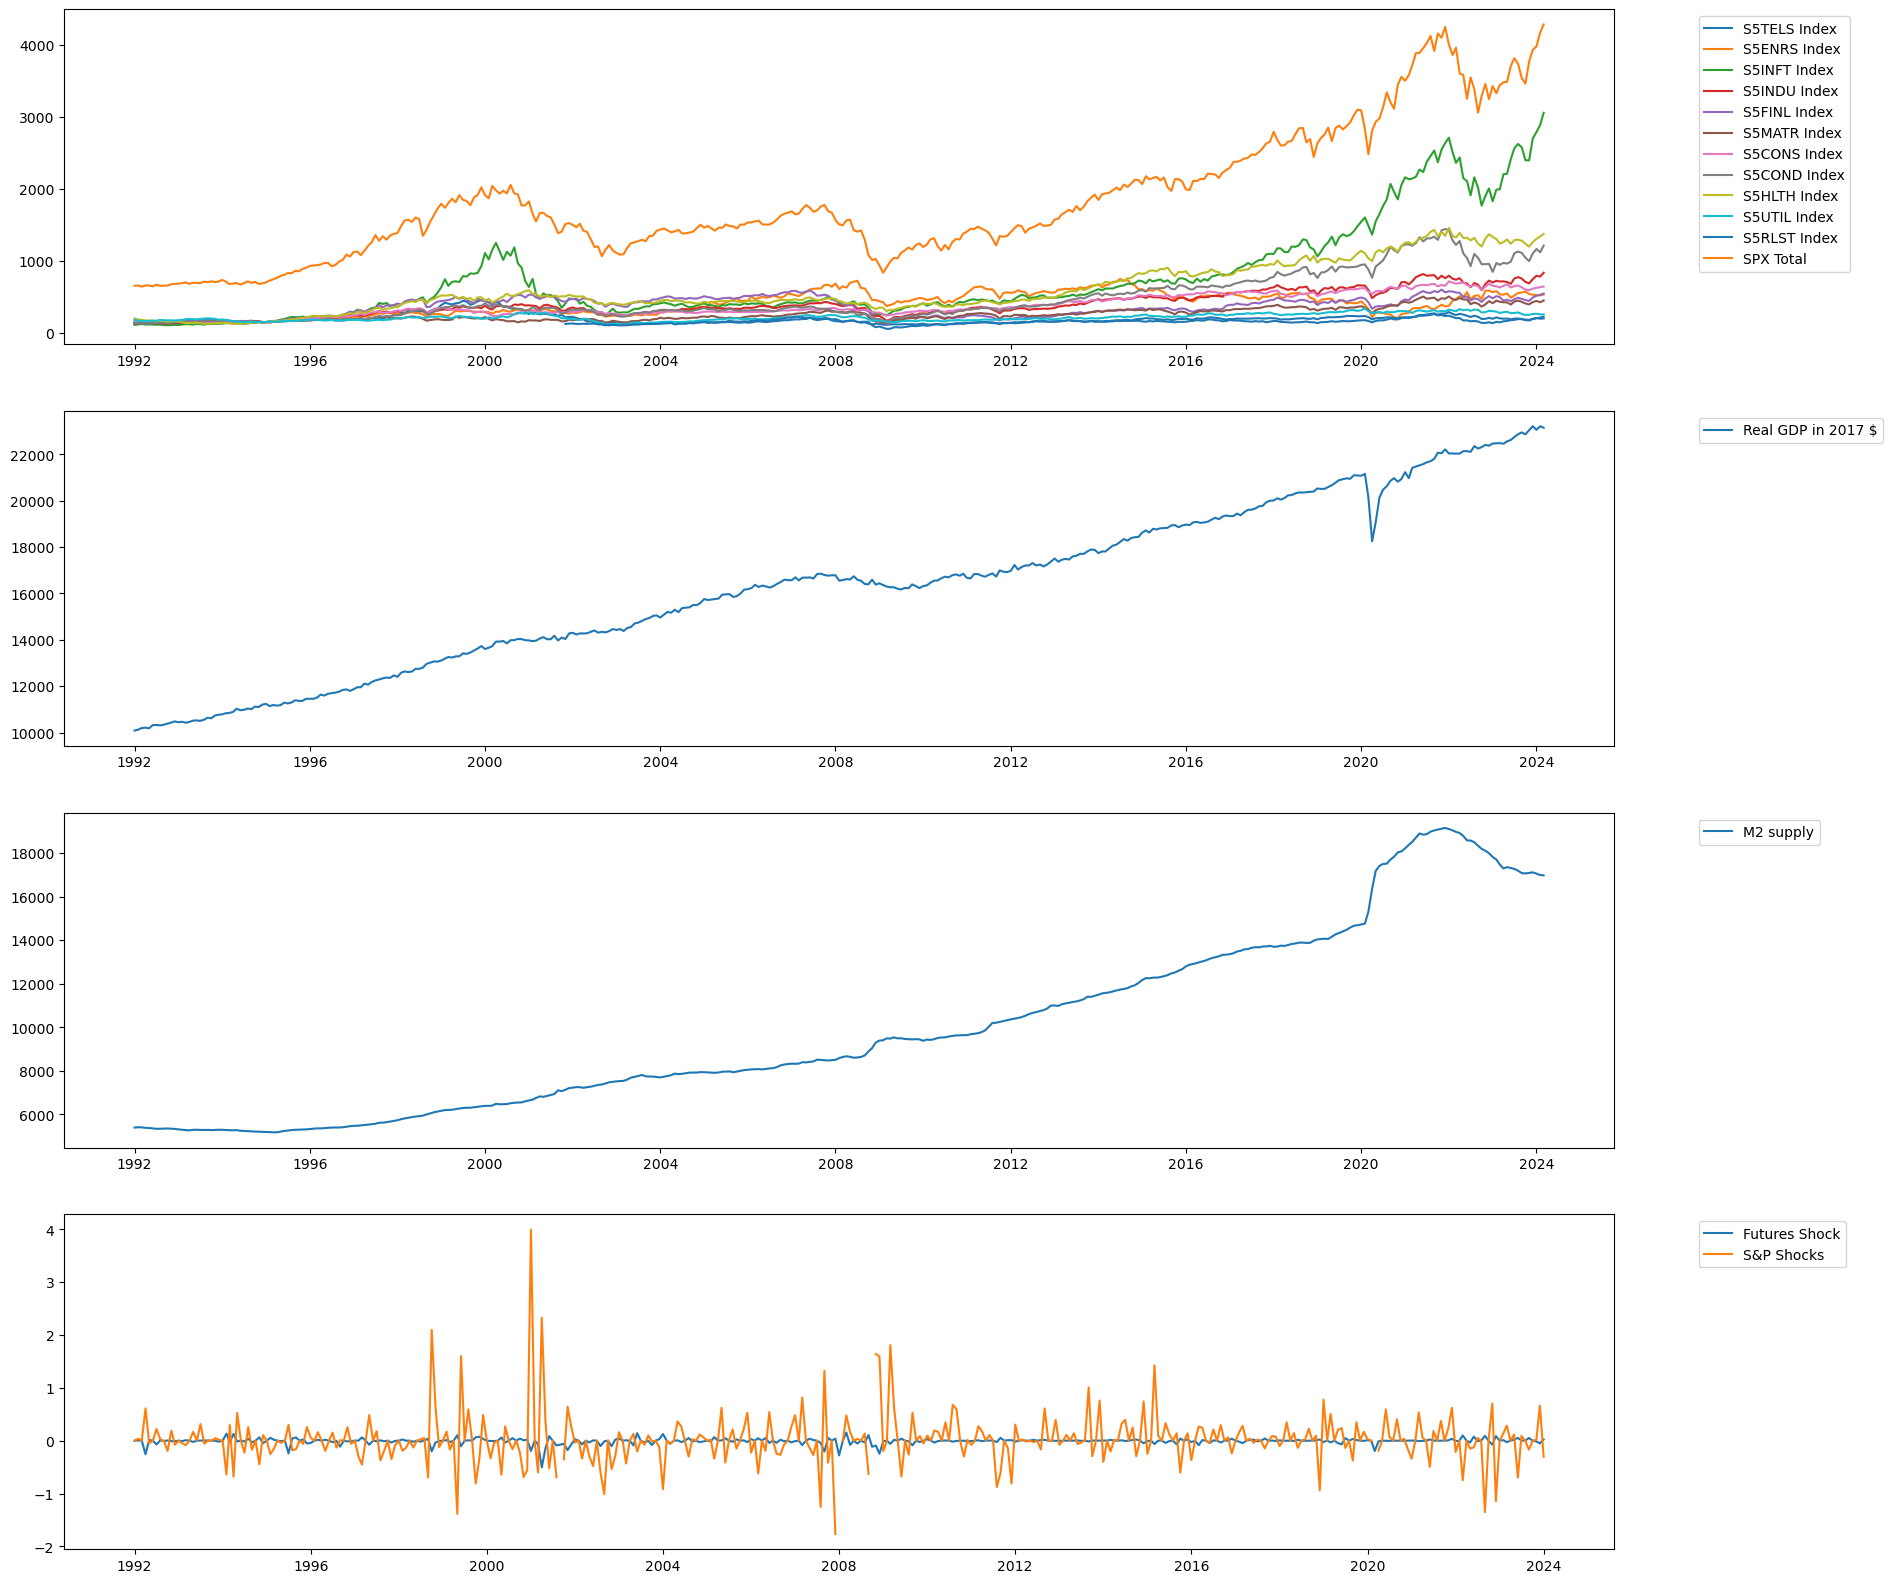

In [5]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(411)
ax.plot(real_vars.index, real_vars[industry_names])
ax.legend(real_vars[industry_names].columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(412)
ax.plot(real_vars.index, real_vars['GDP'])
ax.legend(['Real GDP in 2017 $'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(413)
ax.plot(real_vars.index, real_vars[['M2SL']])
ax.legend(['M2 supply'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(414)
ax.plot(data.index, data[['Futures Shock', 'SPX Shock']])
ax.legend(['Futures Shock', 'S&P Shocks'], bbox_to_anchor=(1.05, 1), loc='upper left')

We perform A standard ADF and Phillips Perrin test for stationarity. The Phillips Perrin methodologya ccounts for Newey west standard errors (robust to serial correlation and heteroskedasticity).

Information technologies and the total S&P 500 are stationary under the PP tests.


In [6]:
summary_df = pd.DataFrame(index=['ADF Test'])
summary_df = summary_df.astype(str)

# Perform ADF test with Newey-West standard errors for each variable
for industry in industry_names:
    summary_df = run_tests_ct(real_vars[industry], summary_df)

run_tests_ct(real_vars['GDP'], summary_df)
run_tests_ct(real_vars['M2SL'], summary_df)
run_tests_c(data['Futures Shock'], summary_df)
run_tests_c(data['SPX Shock'], summary_df)

/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_38062/543352185.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.83' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_38062/543352185.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.12' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_38062/543352185.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13' has dtype

S5TELS Index S5ENRS Index S5INFT Index S5INDU Index S5FINL Index  \
ADF Test        -2.83        -2.12         0.13        -2.27        -2.16   

         S5MATR Index S5CONS Index S5COND Index S5HLTH Index S5UTIL Index  \
ADF Test         -2.8        -1.81        -1.69        -1.15       -3.23*   

         S5RLST Index SPX Total    GDP   M2SL Futures Shock  SPX Shock  
ADF Test        -2.73     -1.42  -1.81  -2.95     -10.36***  -10.94***

Given the previous results, we implement Newey West standard errors to account for the heteroskedasticty of the error terms. All variables become non-stationary.

Given the shape of the graphs, it seems that there may be a compounding effect going on with the industry indeces. We thus convert them to logs and perform the standard ADF test. With this specification, S5MATR Index, S5UTIL Index and M2 are all stationary.

In [7]:
log_vars = np.log(real_vars)
#create log difference
log_vars = log_vars.diff()
treated_vars = log_vars.copy()
treated_vars[['Futures Shock', 'SPX Shock']] = data[['Futures Shock', 'SPX Shock']]


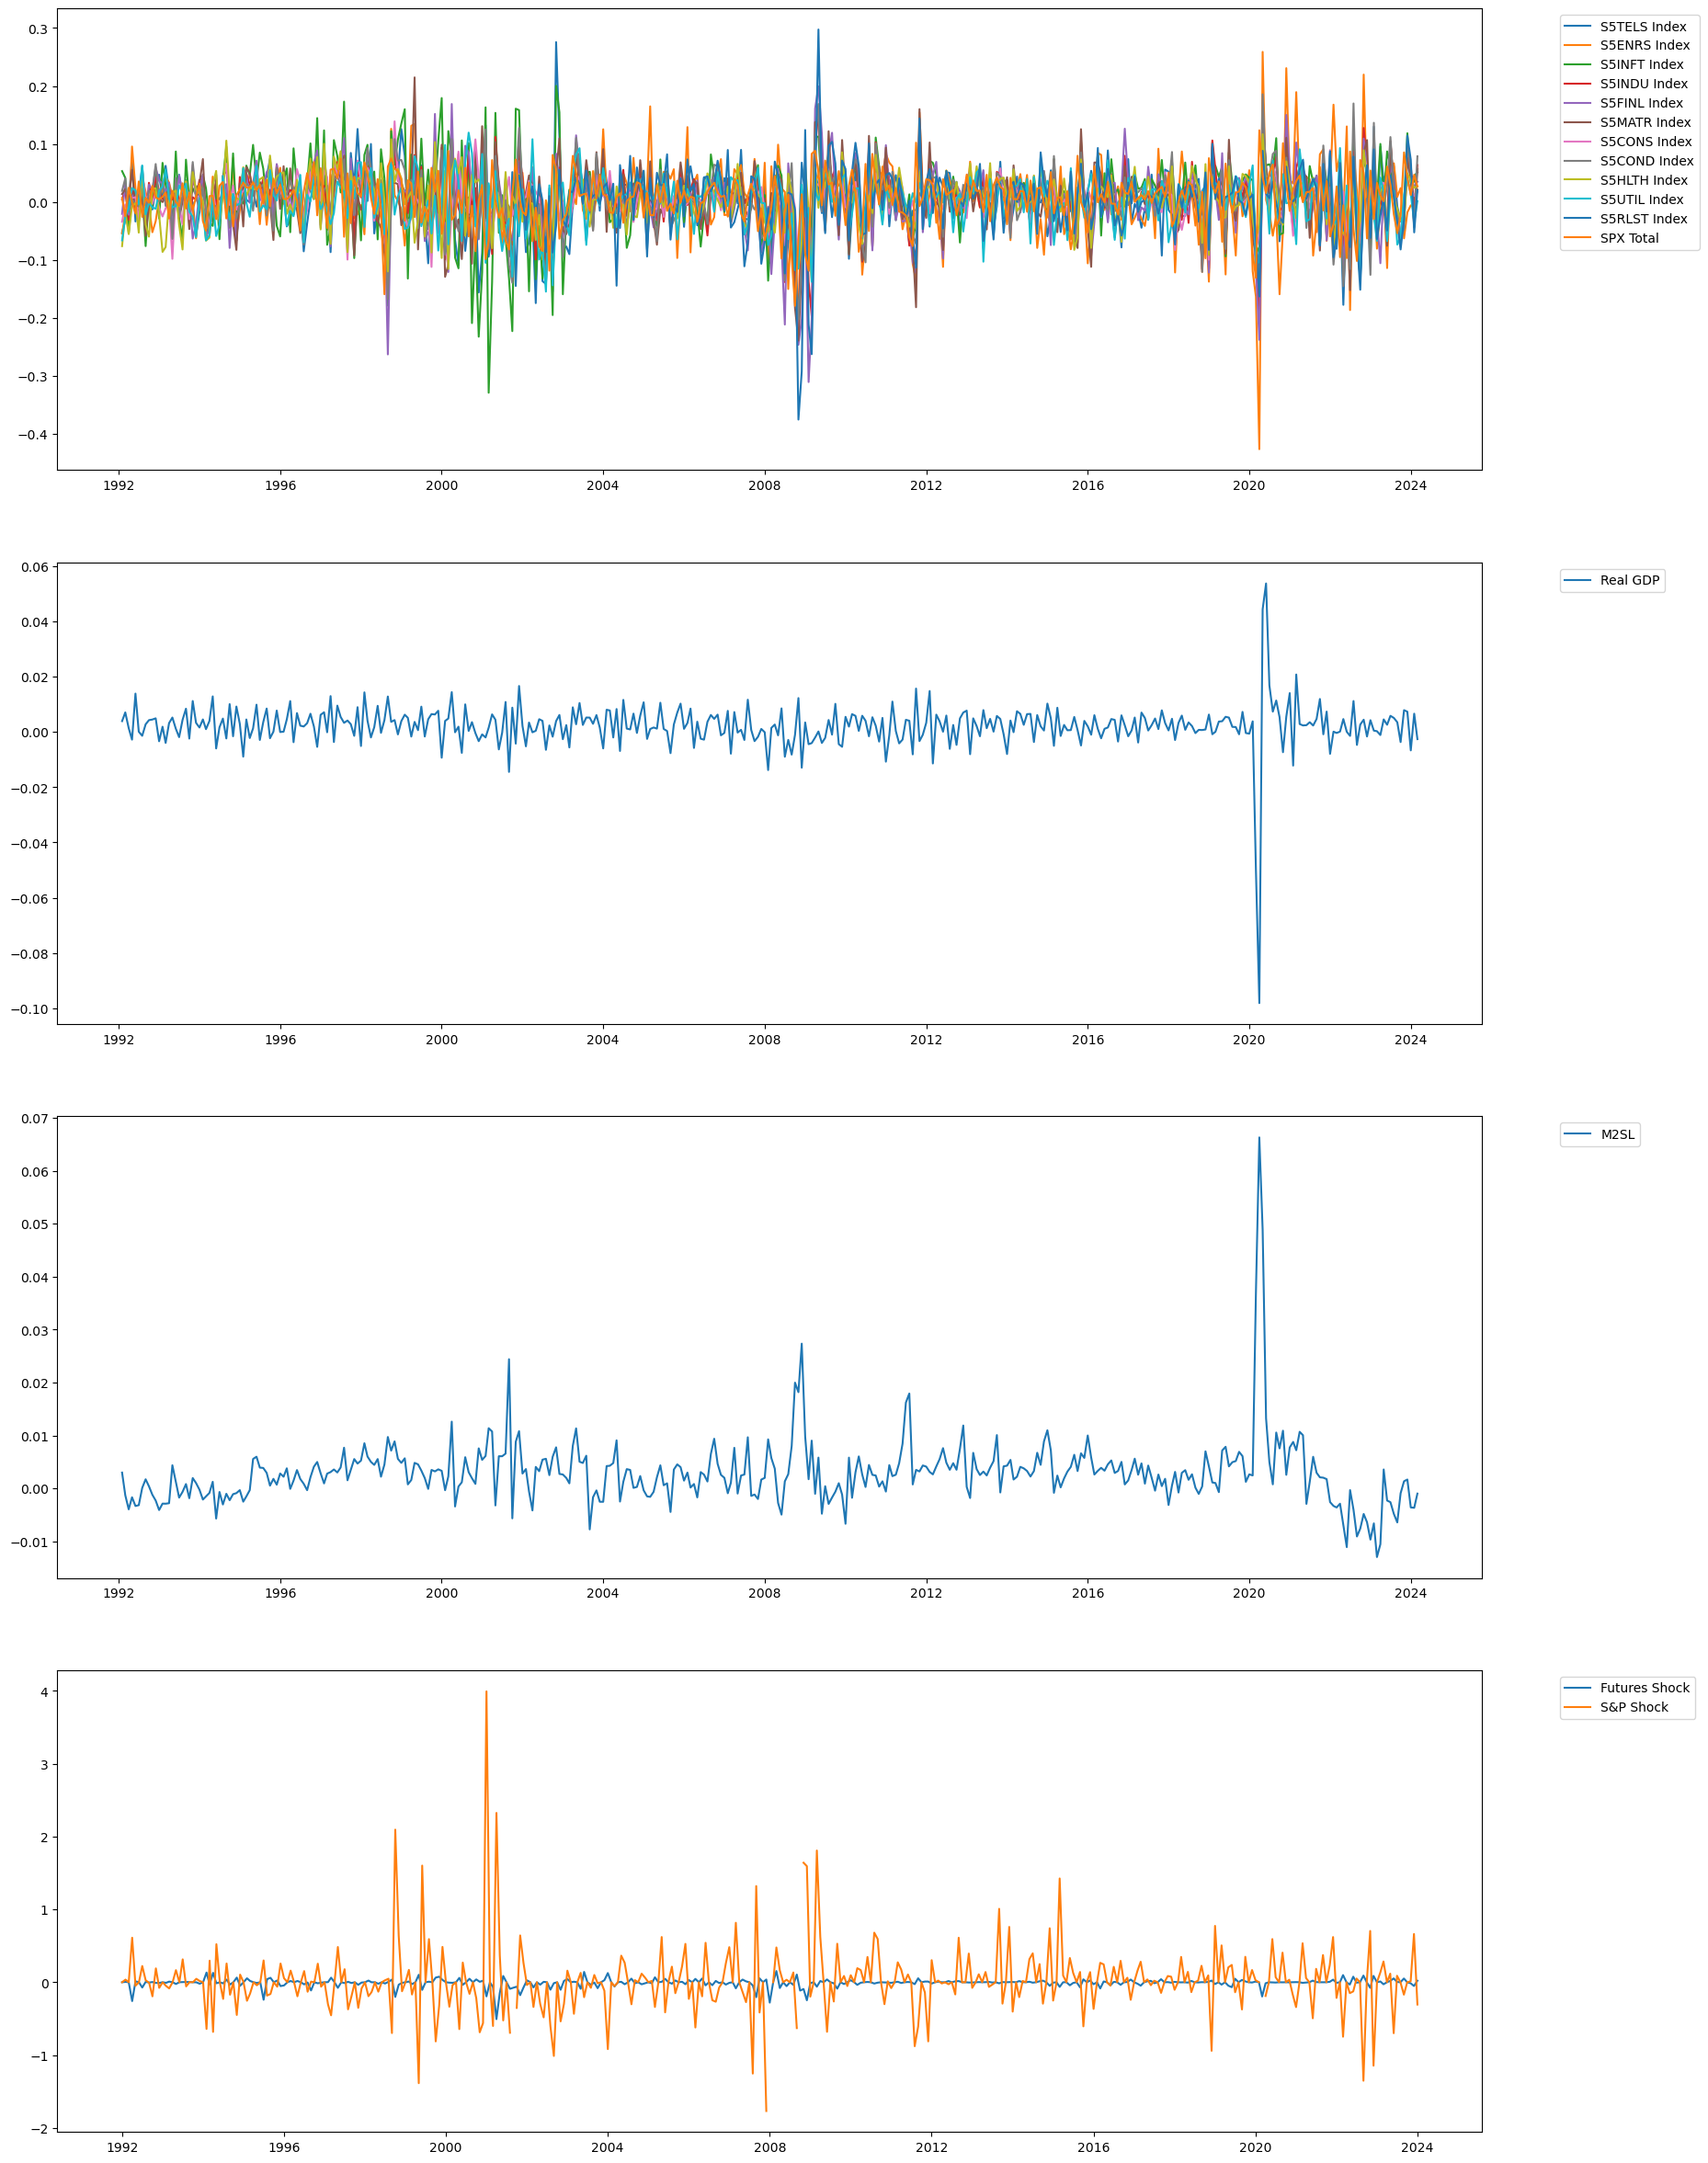

In [8]:
plt.figure(figsize=(20, 30))
ax = plt.subplot(411)
ax.plot(treated_vars.index, treated_vars[industry_names])
ax.legend(treated_vars[industry_names].columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(412)
ax.plot(treated_vars.index, treated_vars[['GDP']])
ax.legend(['Real GDP'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(413)
ax.plot(treated_vars.index, treated_vars[[ 'M2SL']])
ax.legend(['M2SL'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(414)
ax.plot(data.index, treated_vars[['Futures Shock', 'SPX Shock']])
ax.legend(['Futures Shock', 'S&P Shock'], bbox_to_anchor=(1.05, 1), loc='upper left')

In [9]:
summary_df = pd.DataFrame(index=['ADF Test'])
summary_df = summary_df.astype(str)

# Perform ADF test with Newey-West standard errors for each variable
for industry in industry_names:
    summary_df = run_tests_ct(treated_vars[industry], summary_df)

run_tests_c(treated_vars['GDP'], summary_df)
run_tests_c(treated_vars['M2SL'], summary_df)
run_tests_c(treated_vars['Futures Shock'], summary_df)
run_tests_c(treated_vars['SPX Shock'], summary_df)

/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_38062/543352185.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-4.98***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_38062/543352185.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-21.12***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_38062/543352185.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-10.16**

S5TELS Index S5ENRS Index S5INFT Index S5INDU Index S5FINL Index  \
ADF Test     -4.98***    -21.12***    -10.16***    -14.81***     -7.98***   

         S5MATR Index S5CONS Index S5COND Index S5HLTH Index S5UTIL Index  \
ADF Test    -20.34***    -15.18***    -15.15***     -5.15***     -5.84***   

         S5RLST Index  SPX Total        GDP      M2SL Futures Shock  SPX Shock  
ADF Test     -6.66***  -19.51***  -12.48***  -5.71***     -10.36***  -10.94***

In [10]:
# Calculate inverse roots
inverse_roots = 1 / roots

# Create a new figure
plt.figure()

# Plot the real part on the x-axis and the imaginary part on the y-axis
plt.scatter(inverse_roots.real, inverse_roots.imag)

# Add a unit circle for reference
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

# Set the x and y limits to be the same
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

# Set the aspect ratio to be equal, so the circle looks like a circle
plt.gca().set_aspect('equal', adjustable='box')

# Add labels and title
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Inverse Roots of AR Characteristic Polynomial')

# Show the plot
plt.show()

NameError: name 'roots' is not defined

# VECM model

In [31]:
#create a dummy variable = 1 for observations between dates 2000-01-01 and 2001-01-01, 2008-01-01 and 2009-01-01, and 2020-01-01 and 2021-01-01, and 0 otherwise
dummy_vars = pd.DataFrame(index = treated_vars.index)
dummy_vars['dummy'] = 0
#controlling for dot com crash
dummy_vars.loc['2000-03-01':'2002-01-01', 'dummy'] = 1
#2008 Financial crisis
dummy_vars.loc['2007-12-01':'2009-06-01', 'dummy'] = 1
#Covid Pandemic
dummy_vars.loc['2020-01-01':'2021-01-01', 'dummy'] = 1

treated_vars['Recession Dummy'] = dummy_vars

# Fill the exogenous forecast with predicted values of the dummy (which are all 0)
exog_forecast = pd.DataFrame(index=pd.date_range(start=treated_vars.index[-1], periods=12, freq='M'))
exog_forecast['Recession Dummy'] = 0

/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_38062/37668173.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  exog_forecast = pd.DataFrame(index=pd.date_range(start=treated_vars.index[-1], periods=12, freq='M'))


In [50]:



treated_vars


Futures Shock  S5TELS Index  S5ENRS Index  S5INFT Index  \
Date                                                                  
1992-01-01       0.000000           NaN           NaN           NaN   
1992-02-01       0.004572     -0.052566     -0.054455      0.053308   
1992-03-01       0.000000     -0.031876     -0.021501      0.041631   
1992-04-01      -0.258935     -0.002941     -0.035854     -0.053867   
1992-05-01       0.012382      0.075694      0.095669      0.010828   
...                   ...           ...           ...           ...   
2023-11-01      -0.013891     -0.020122     -0.062579     -0.000588   
2023-12-01      -0.051664      0.073960     -0.017846      0.118548   
2024-01-01       0.021353      0.042961     -0.005684      0.033444   
2024-02-01            NaN      0.043954     -0.008525      0.035011   
2024-03-01            NaN      0.051299      0.021716      0.056370   

            S5INDU Index  S5FINL Index  S5MATR Index  S5CONS Index  \
Date                                                                 
1992-01-01           NaN           NaN           NaN           NaN   
1992-02-01      0.004508     -0.020453      0.013739     -0.034071   
1992-03-01      0.021393      0.031914      0.022213     -0.003909   
1992-04-01     -0.030962     -0.021894      0.001642     -0.015139   
1992-05-01      0.020519      0.009154      0.055536      0.006625   
...                  ...           ...           ...           ...   
2023-11-01     -0.030031     -0.026486     -0.032572     -0.013695   
2023-12-01      0.080417      0.100215      0.076229      0.035518   
2024-01-01      0.062450      0.047433      0.038671      0.020212   
2024-02-01     -0.012562      0.025303     -0.043424      0.010329   
2024-03-01      0.063724      0.035086      0.057076      0.017270   

            S5COND Index  S5HLTH Index  S5UTIL Index  S5RLST Index  SPX Total  \
Date                                                                            
1992-01-01           NaN           NaN           NaN           NaN        NaN   
1992-02-01      0.019169     -0.076074     -0.066100           NaN   0.006960   
1992-03-01      0.040601     -0.018290     -0.025025           NaN  -0.024466   
1992-04-01     -0.016852     -0.055305     -0.010643           NaN   0.024669   
1992-05-01      0.005028     -0.006625      0.023956           NaN  -0.000126   
...                  ...           ...           ...           ...        ...   
2023-11-01     -0.046010     -0.033808      0.012299     -0.029655   0.085532   
2023-12-01      0.100945      0.049755      0.042988      0.114500   0.042020   
2024-01-01      0.055185      0.036826      0.012995      0.072873   0.012003   
2024-02-01     -0.039503      0.024712     -0.034400     -0.052366   0.047119   
2024-03-01      0.078761      0.026875      0.001512      0.020480   0.026822   

                 GDP      M2SL  SPX Shock  Recession Dummy  
Date                                                        
1992-01-01       NaN       NaN    0.00000                0  
1992-02-01  0.003901  0.003010    0.03621                0  
1992-03-01  0.007067 -0.001271    0.00000                0  
1992-04-01  0.001374 -0.003932    0.61127                0  
1992-05-01 -0.002797 -0.001654   -0.04802                0  
...              ...       ...        ...              ...  
2023-11-01  0.007875  0.001372    0.01259                0  
2023-12-01  0.007313  0.001696    0.66225                0  
2024-01-01 -0.006675 -0.003567   -0.30595                0  
2024-02-01  0.006599 -0.003642        NaN                0  
2024-03-01 -0.002605 -0.000962        NaN                0  

[387 rows x 17 columns]

In [12]:
# Specify the endogenous variables
endog_vars = [var for var in treated_vars if var not in industry_names and var not in ['Recession Dummy']]

# Specify the exogenous variables
exog_vars = ['Recession Dummy']

industry_dataframes = create_industry_dfs(treated_vars, industry_names, endog_vars, exog_vars)
industry_dataframes

{'S5TELS Index': {'industry_df':             Futures Shock  S5TELS Index       GDP      M2SL
  Date                                                       
  1992-02-01       0.004572     -0.052566  0.003901  0.003010
  1992-03-01       0.000000     -0.031876  0.007067 -0.001271
  1992-04-01      -0.258935     -0.002941  0.001374 -0.003932
  1992-05-01       0.012382      0.075694 -0.002797 -0.001654
  1992-06-01       0.000000     -0.033574  0.013869 -0.003302
  ...                   ...           ...       ...       ...
  2023-09-01       0.051324     -0.007830  0.003497 -0.006404
  2023-10-01       0.000000     -0.033585 -0.003662 -0.000897
  2023-11-01      -0.013891     -0.020122  0.007875  0.001372
  2023-12-01      -0.051664      0.073960  0.007313  0.001696
  2024-01-01       0.021353      0.042961 -0.006675 -0.003567
  
  [384 rows x 4 columns],
  'exogenous_df':             Recession Dummy
  Date                       
  1992-02-01                0
  1992-03-01                

In [24]:
from statsmodels.tsa.vector_ar.var_model import VAR
for industry_name in industry_dataframes.keys():
    industry_df = industry_dataframes[industry_name]['industry_df'].dropna()
    exogenous_df = industry_dataframes[industry_name]['exogenous_df'].dropna()
    
    #make sure both dfs have the same index
    common_index = industry_df.index.intersection(exogenous_df.index)
    industry_df = industry_df.loc[common_index]
    exogenous_df = exogenous_df.loc[common_index]
    # Create a VAR object
    model = VAR(industry_df)

    # Select the VECM model order
    model_order = model.select_order(maxlags=12)

    aic = model_order.aic
    bic = model_order.bic
    fpe = model_order.fpe
    lag_order_df[industry_name] = [aic, bic, fpe, hqic]

lag_order_df

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5TELS Index  S5ENRS Index  S5INFT Index  S5INDU Index  S5FINL Index  \
AIC              2             2             2             2             2   
BIC              1             1             1             1             1   
FPE              2             2             2             2             2   
HQIC             1             1             1             1             1   

      S5MATR Index  S5CONS Index  S5COND Index  S5HLTH Index  S5UTIL Index  \
AIC              2             2             2             2             3   
BIC              1             1             1             1             1   
FPE              2             2             2             2             3   
HQIC             1             1             1             1             1   

      S5RLST Index  SPX Total  
AIC              2          2  
BIC              1          1  
FPE              2          2  
HQIC             1          1

In [25]:
# Specify the maximum number of lags to consider
maxlags = 24

# Specify the deterministic term (e.g., "ci" for constant and trend)
deterministic = "n"

lag_order_df = pd.DataFrame(index=[['AIC', 'BIC', 'FPE', 'HQIC']])

for industry_name in industry_dataframes.keys():
    industry_df = industry_dataframes[industry_name]['industry_df'].dropna()
    exogenous_df = industry_dataframes[industry_name]['exogenous_df'].dropna()
    
    #make sure both dfs have the same index
    common_index = industry_df.index.intersection(exogenous_df.index)
    industry_df = industry_df.loc[common_index]
    exogenous_df = exogenous_df.loc[common_index]

    # Select the VECM model order
    model_order = vecm.select_order(industry_df, maxlags=maxlags, deterministic=deterministic, exog = exogenous_df)
    aic = model_order.aic
    bic = model_order.bic
    fpe = model_order.fpe
    hqic = model_order.hqic
    lag_order_df[industry_name] = [aic, bic, fpe, hqic]

lag_order_df

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5TELS Index  S5ENRS Index  S5INFT Index  S5INDU Index  S5FINL Index  \
AIC              1             1             1             1             1   
BIC              0             0             0             0             0   
FPE              1             1             1             1             1   
HQIC             0             0             0             0             0   

      S5MATR Index  S5CONS Index  S5COND Index  S5HLTH Index  S5UTIL Index  \
AIC              1             1             1             1             3   
BIC              0             0             0             0             0   
FPE              1             1             1             1             3   
HQIC             0             0             0             0             0   

      S5RLST Index  SPX Total  
AIC              1          1  
BIC              0          0  
FPE              1          1  
HQIC             1          1

In [26]:
coint_rank_df = pd.DataFrame(index=[['number of coint vectors']])

for industry_name in industry_dataframes.keys():
    industry_df = industry_dataframes[industry_name]['industry_df']
    
    # Select the VECM model order
    rank = vecm.select_coint_rank(industry_df, det_order=0, k_ar_diff=lag_order_df[industry_name].iloc[0], method='trace', signif=0.05)
    coint_rank_df[industry_name] = rank.rank

coint_rank_df

S5TELS Index  S5ENRS Index  S5INFT Index  \
number of coint vectors             4             4             4   

                         S5INDU Index  S5FINL Index  S5MATR Index  \
number of coint vectors             4             4             4   

                         S5CONS Index  S5COND Index  S5HLTH Index  \
number of coint vectors             4             4             4   

                         S5UTIL Index  S5RLST Index  SPX Total  
number of coint vectors             4             4          4

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

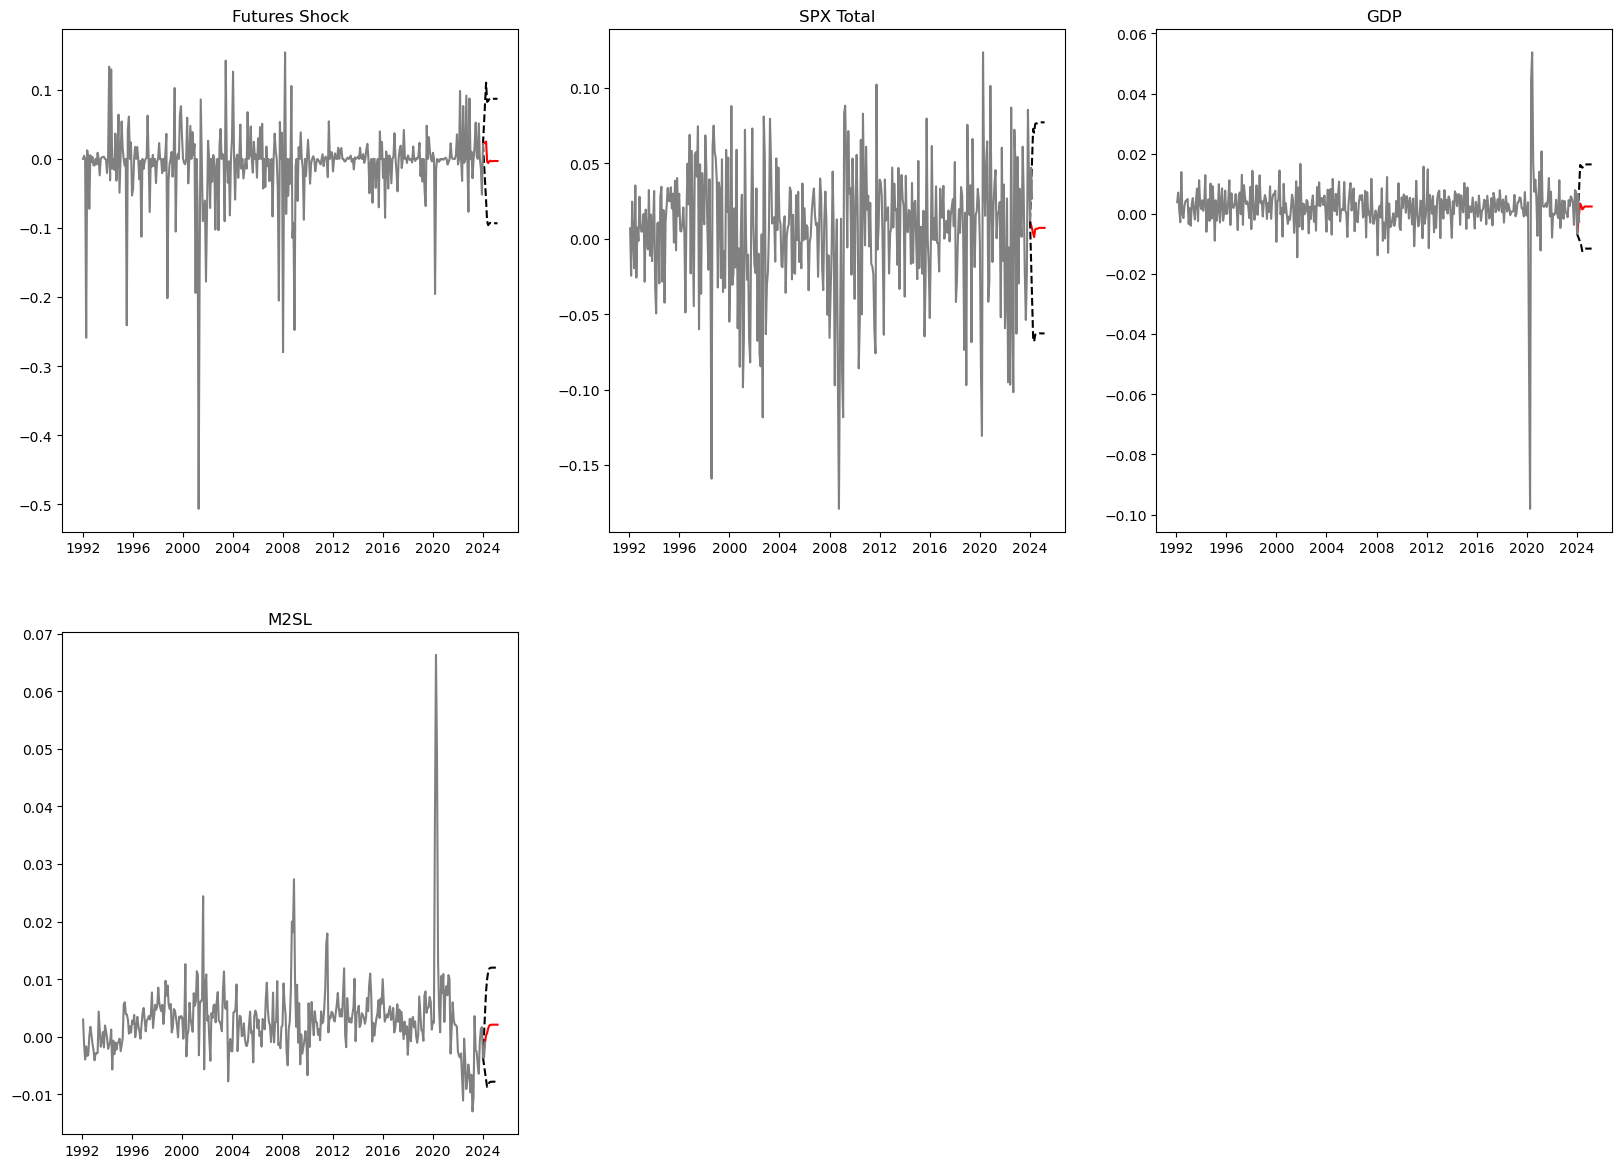

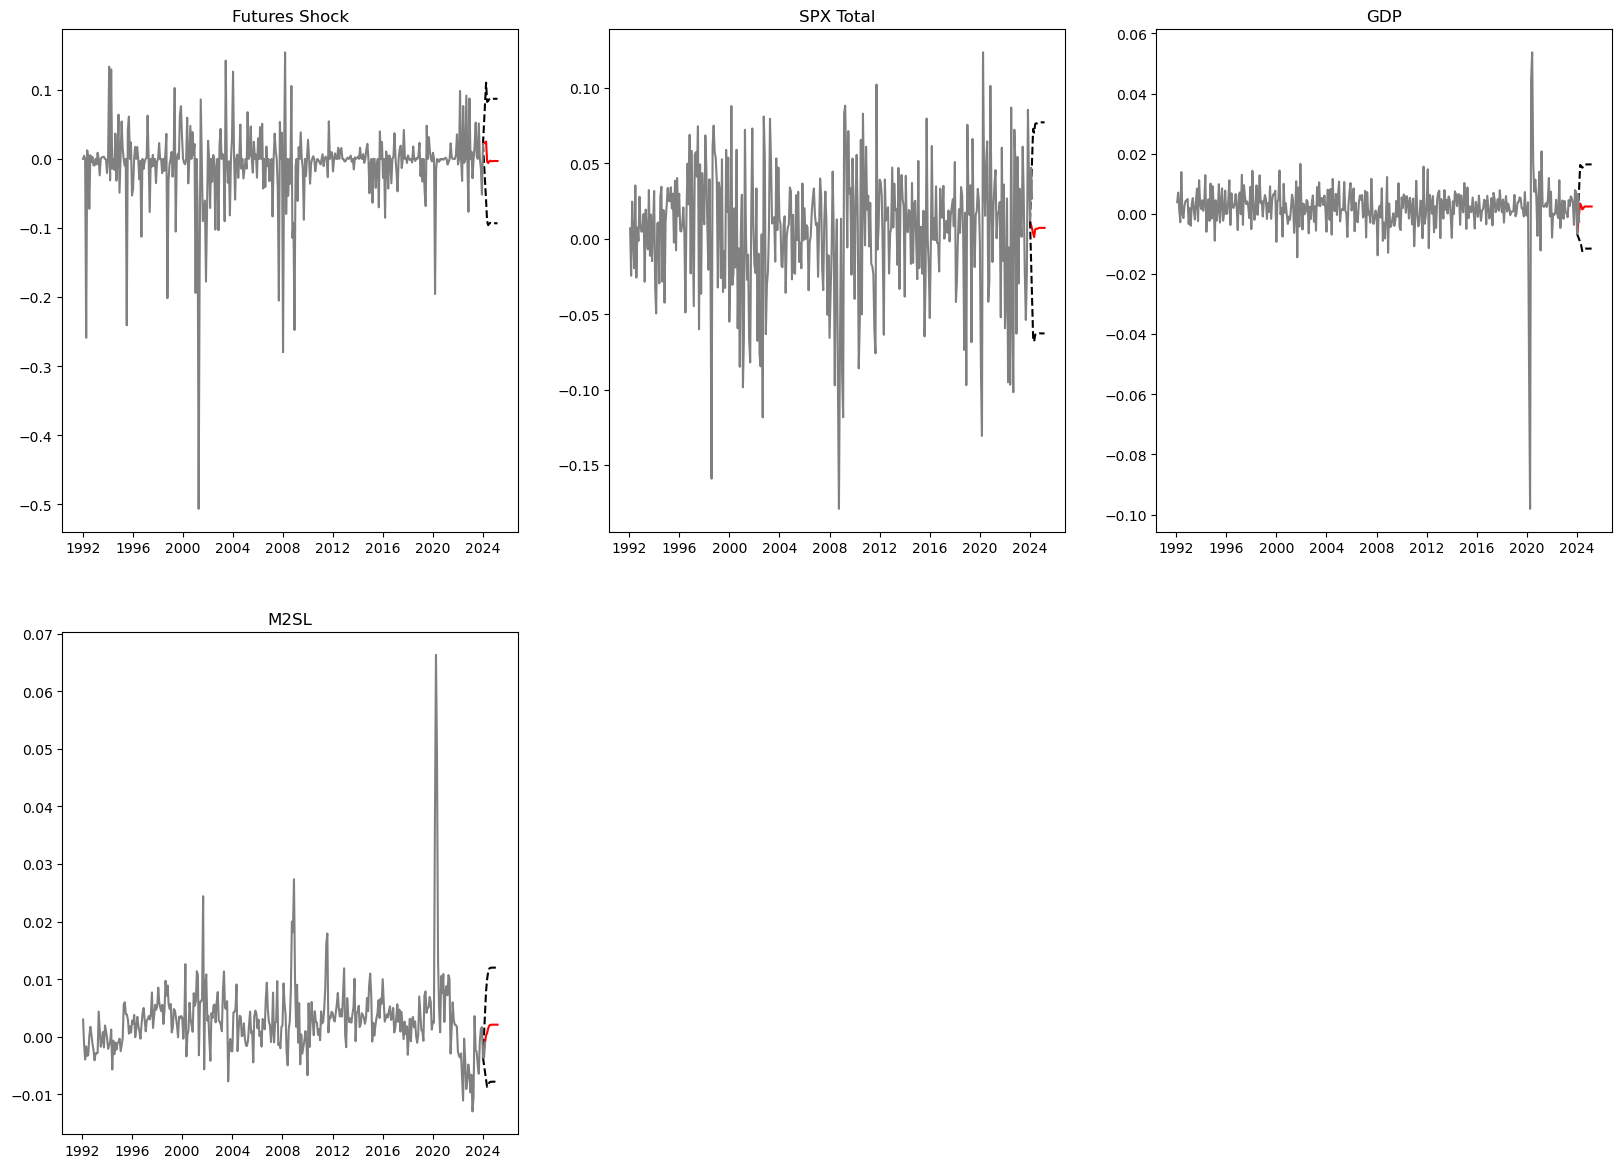

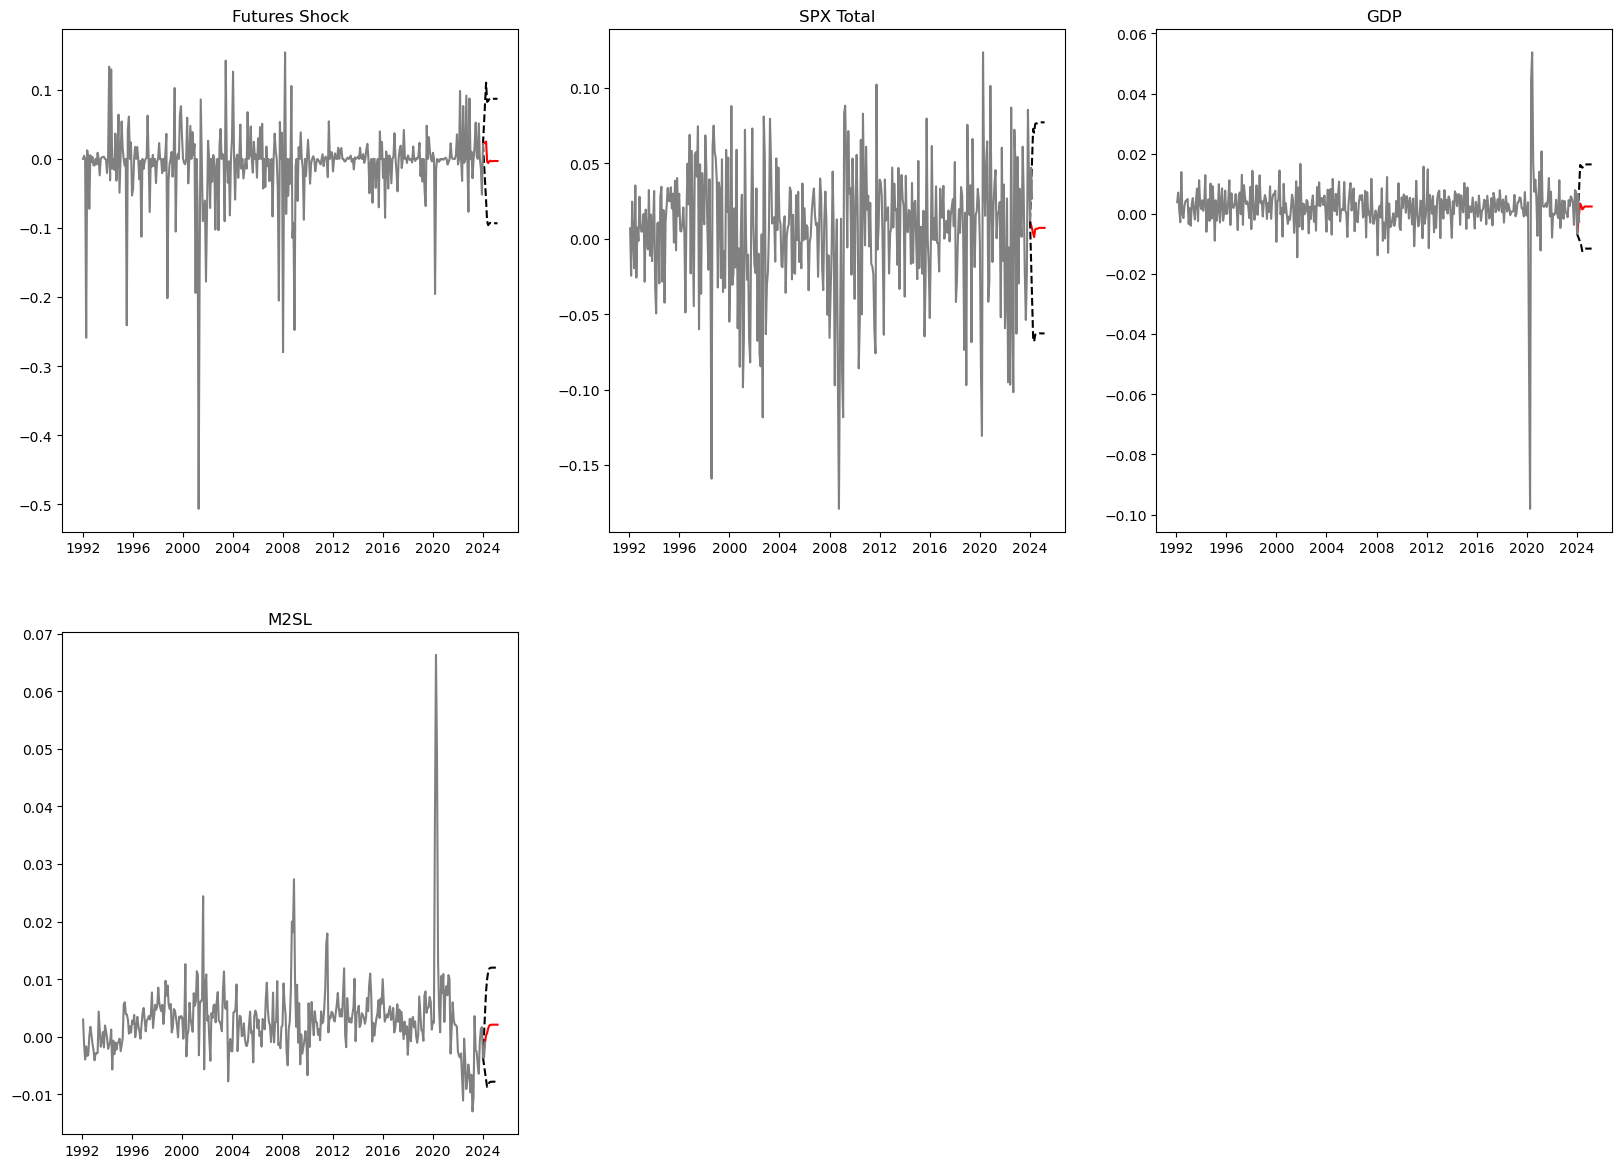

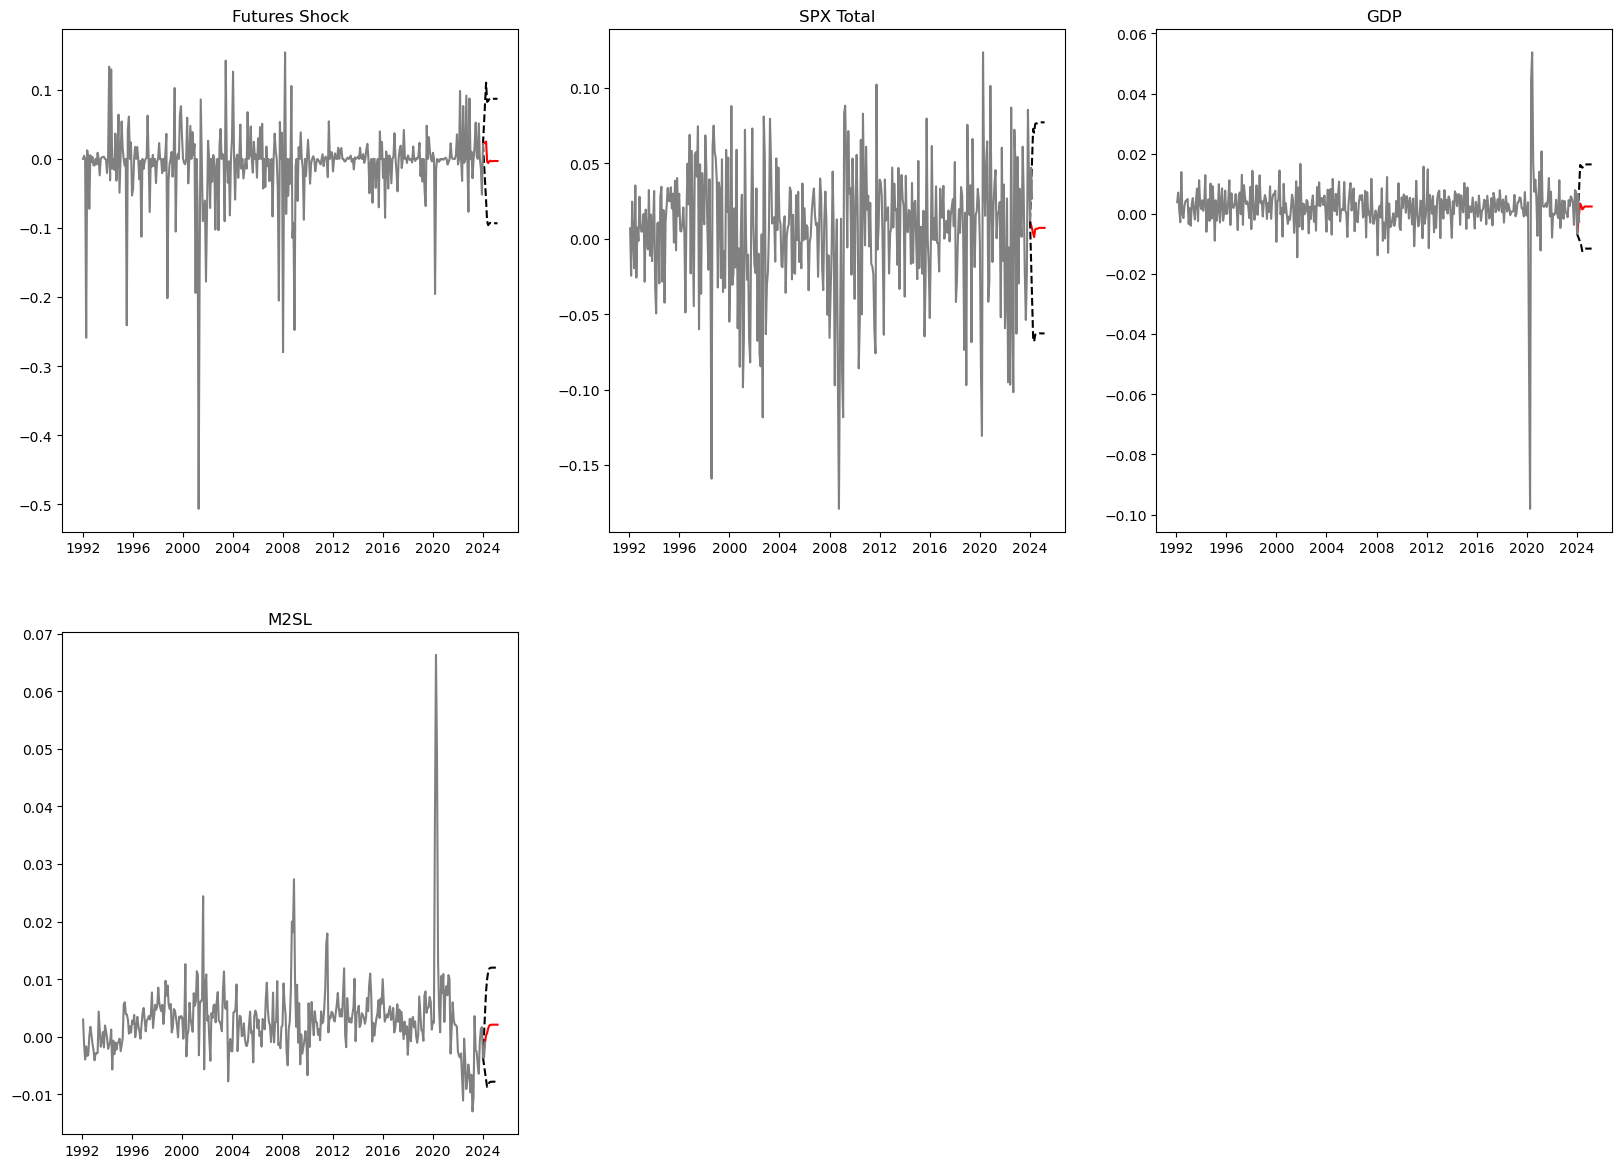

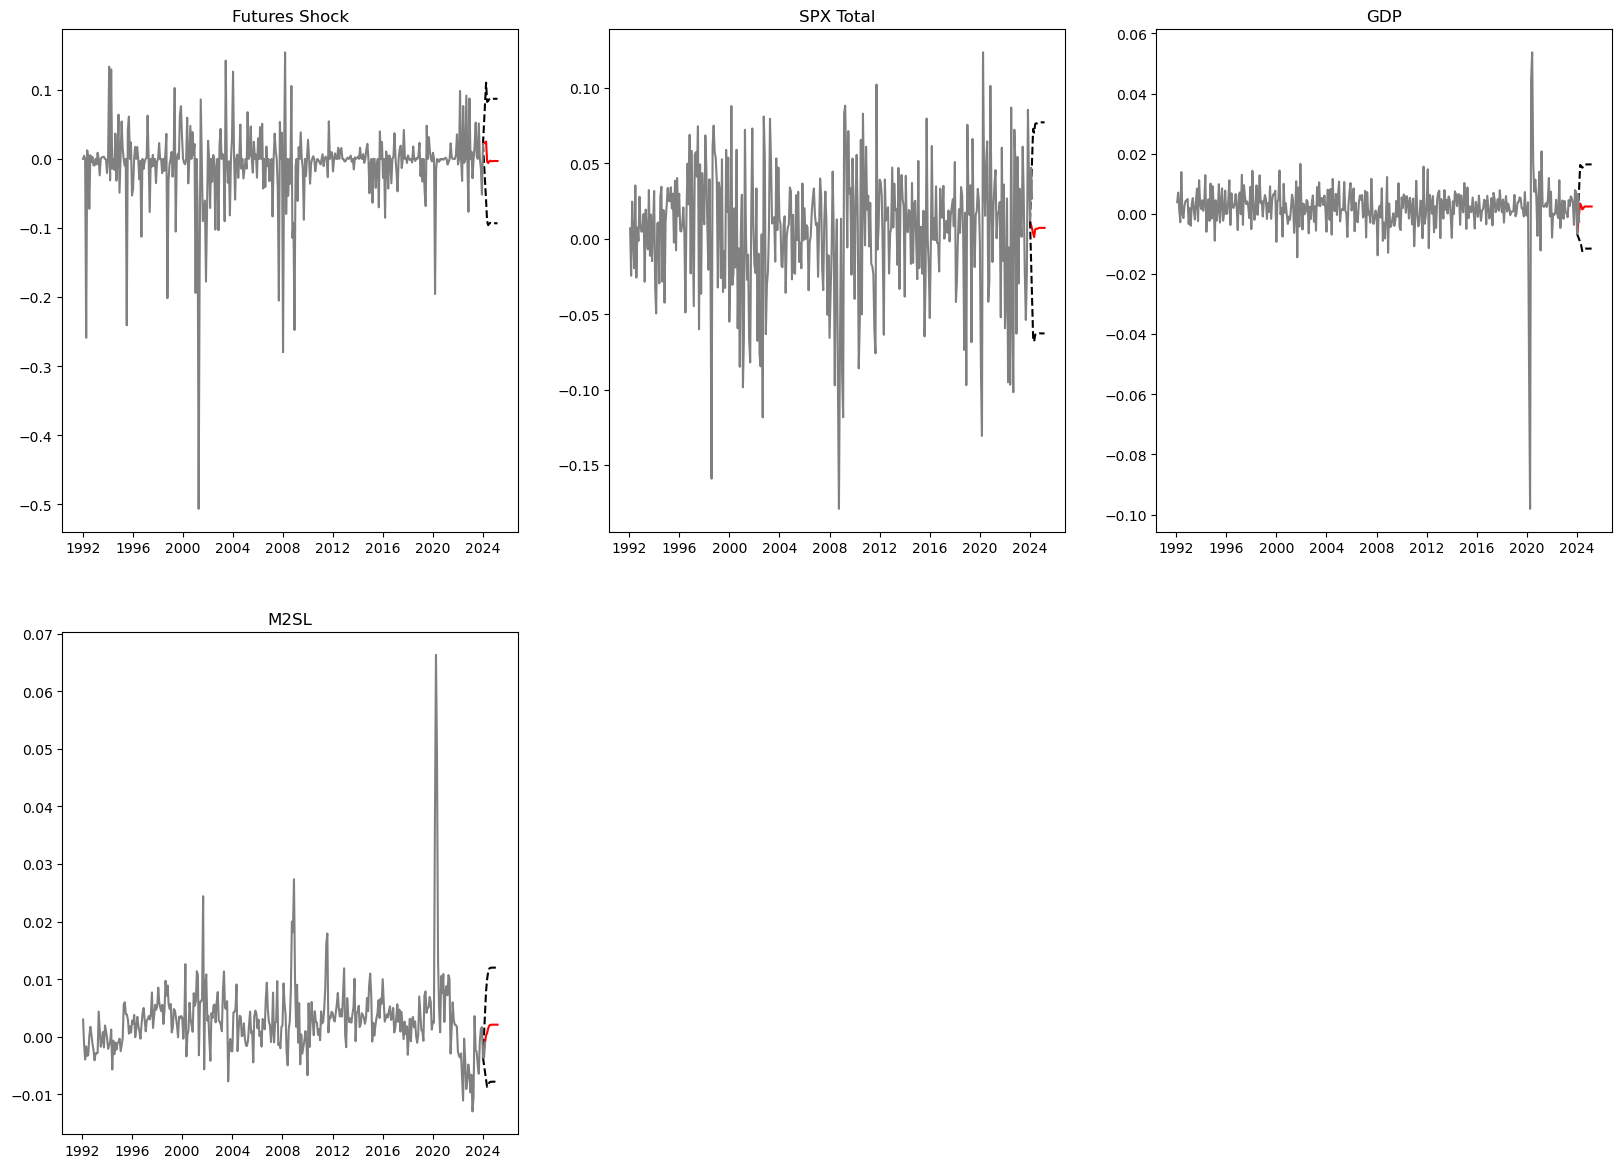

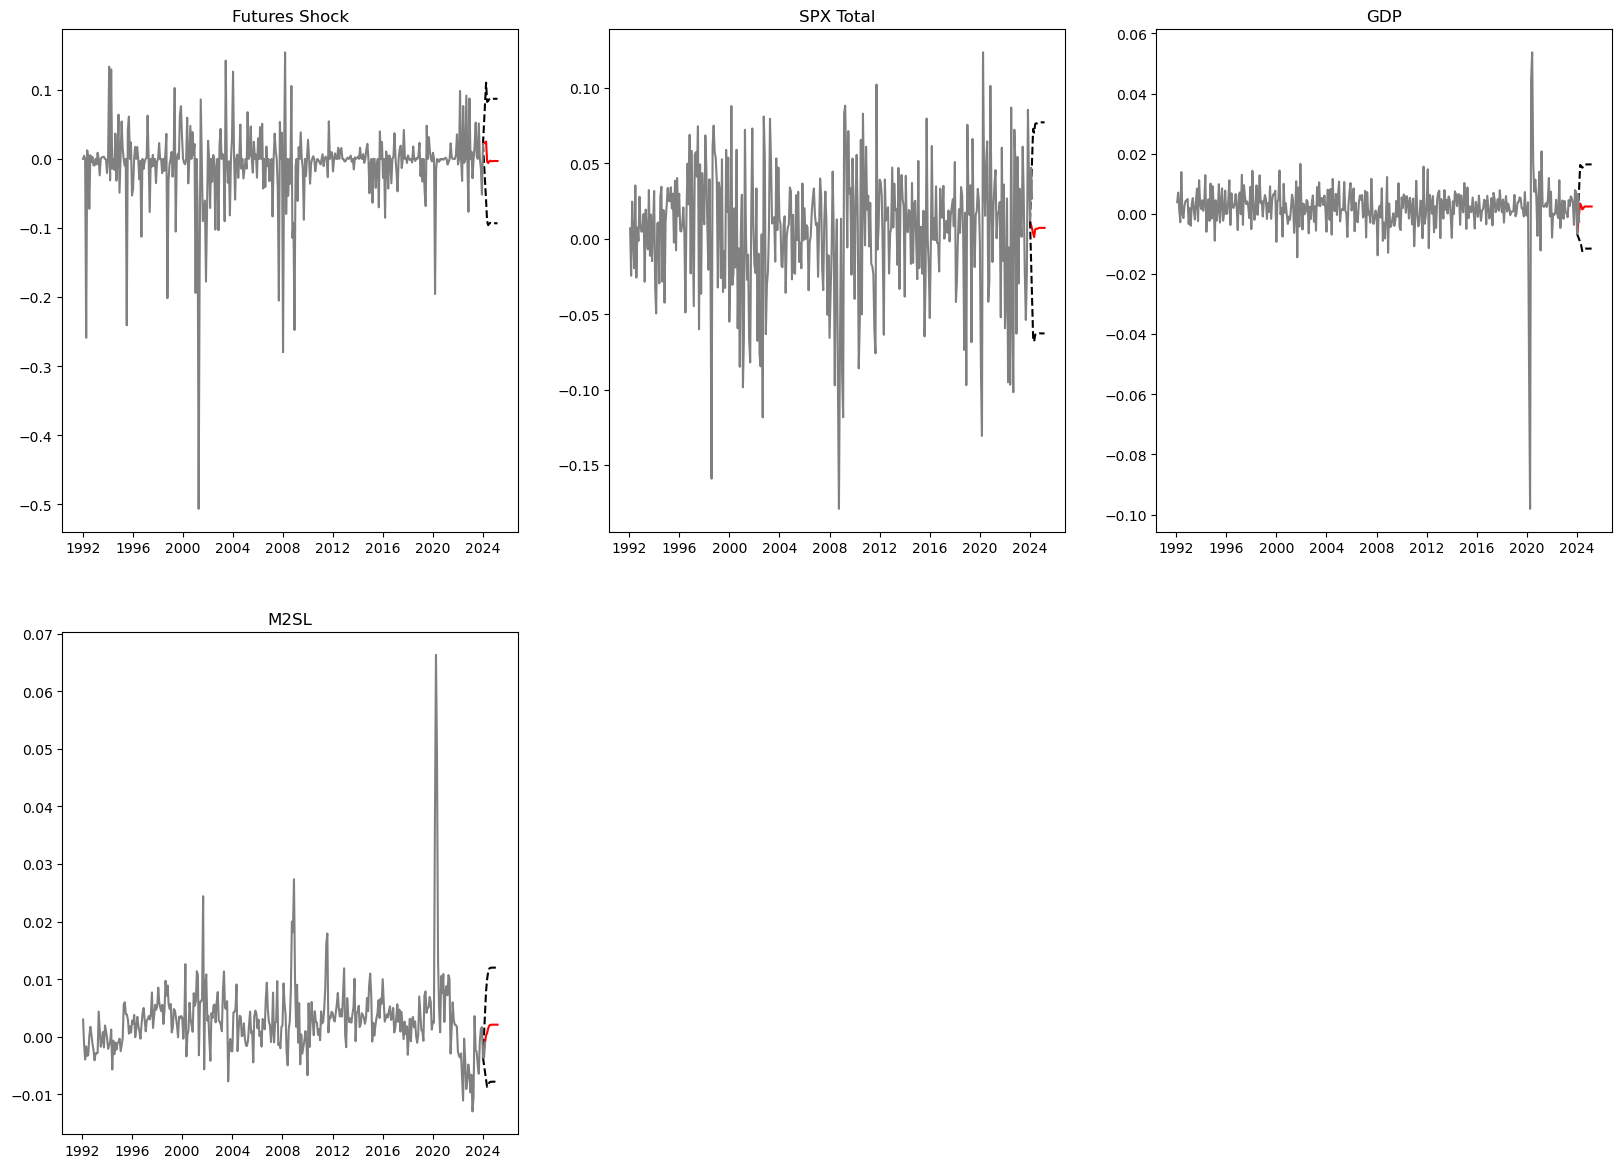

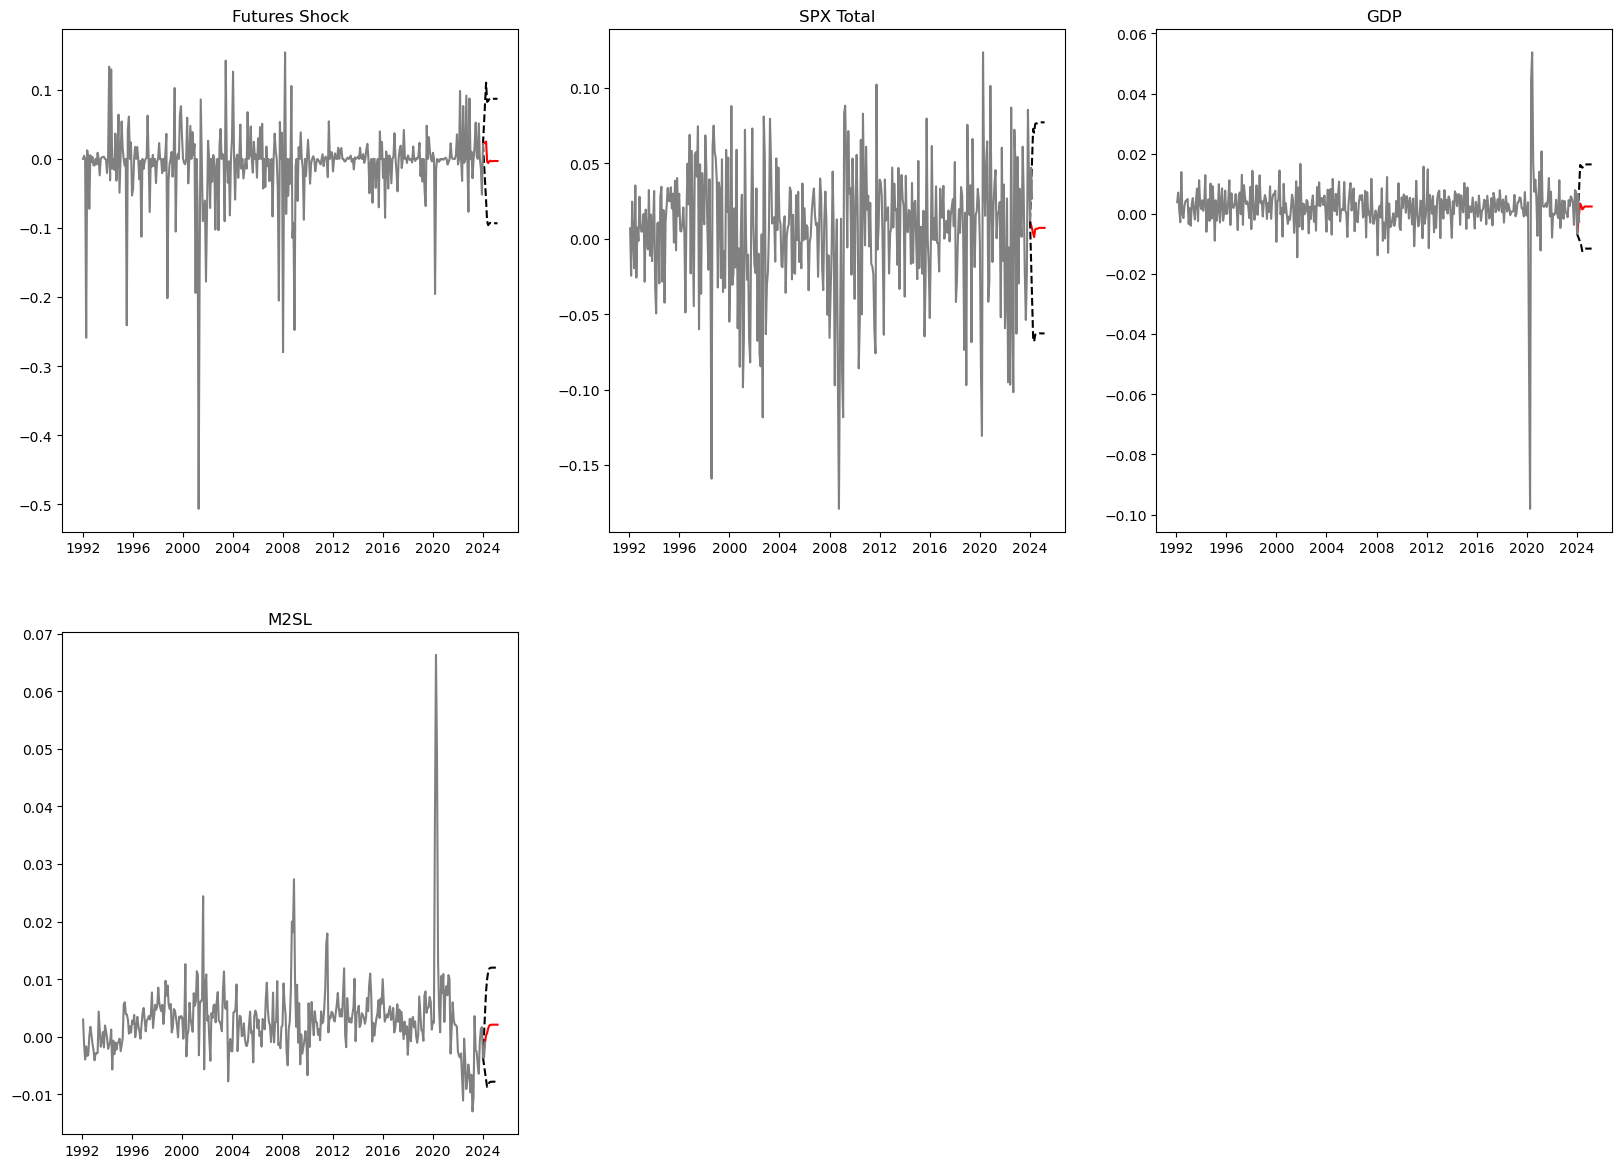

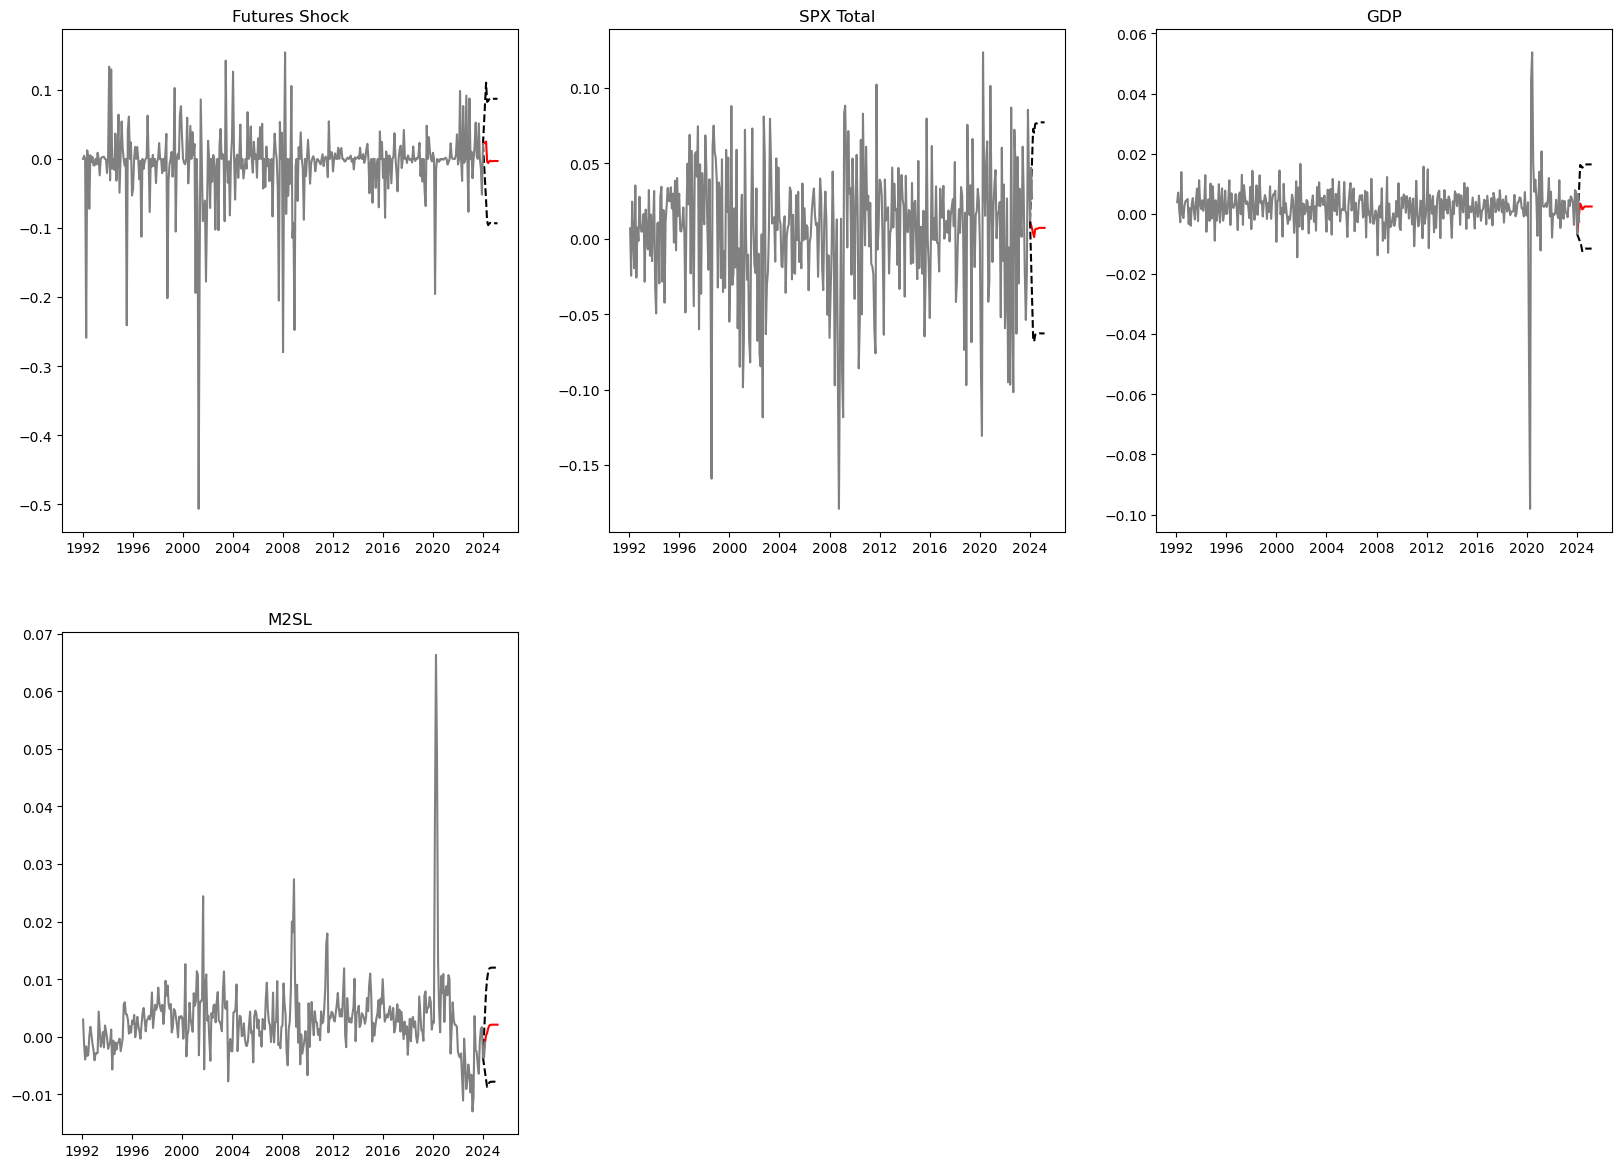

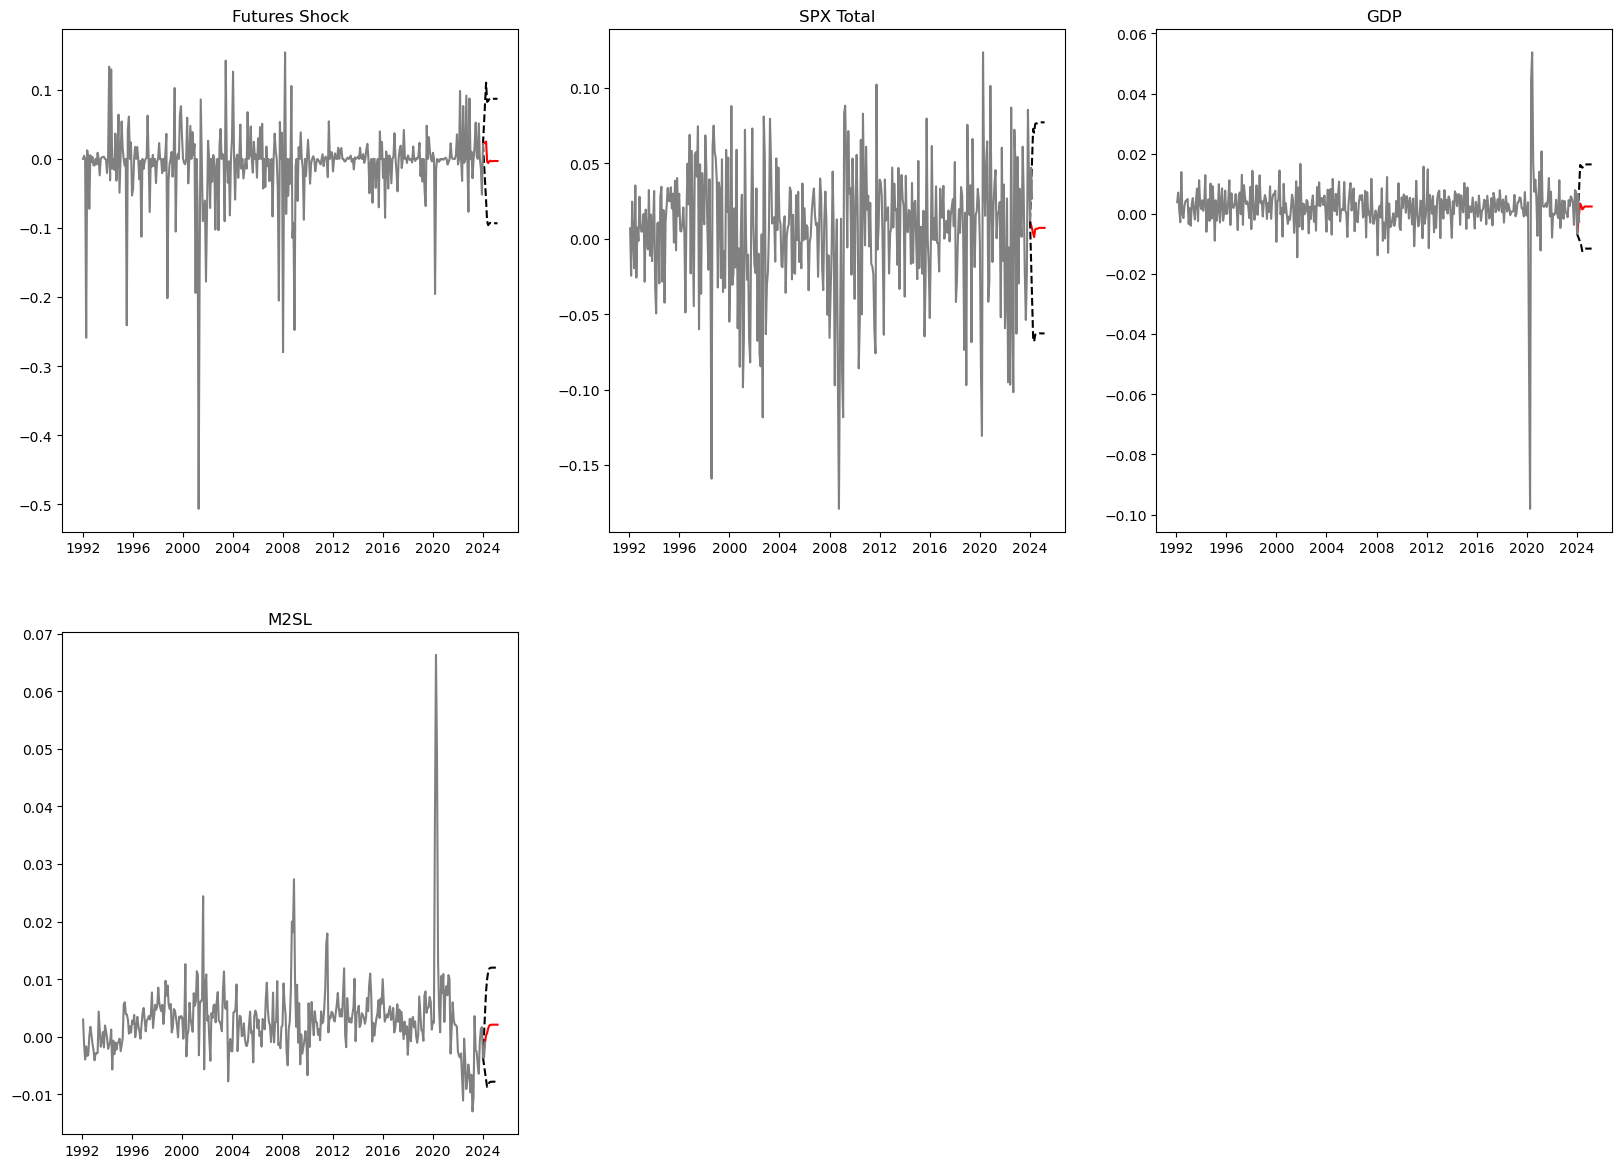

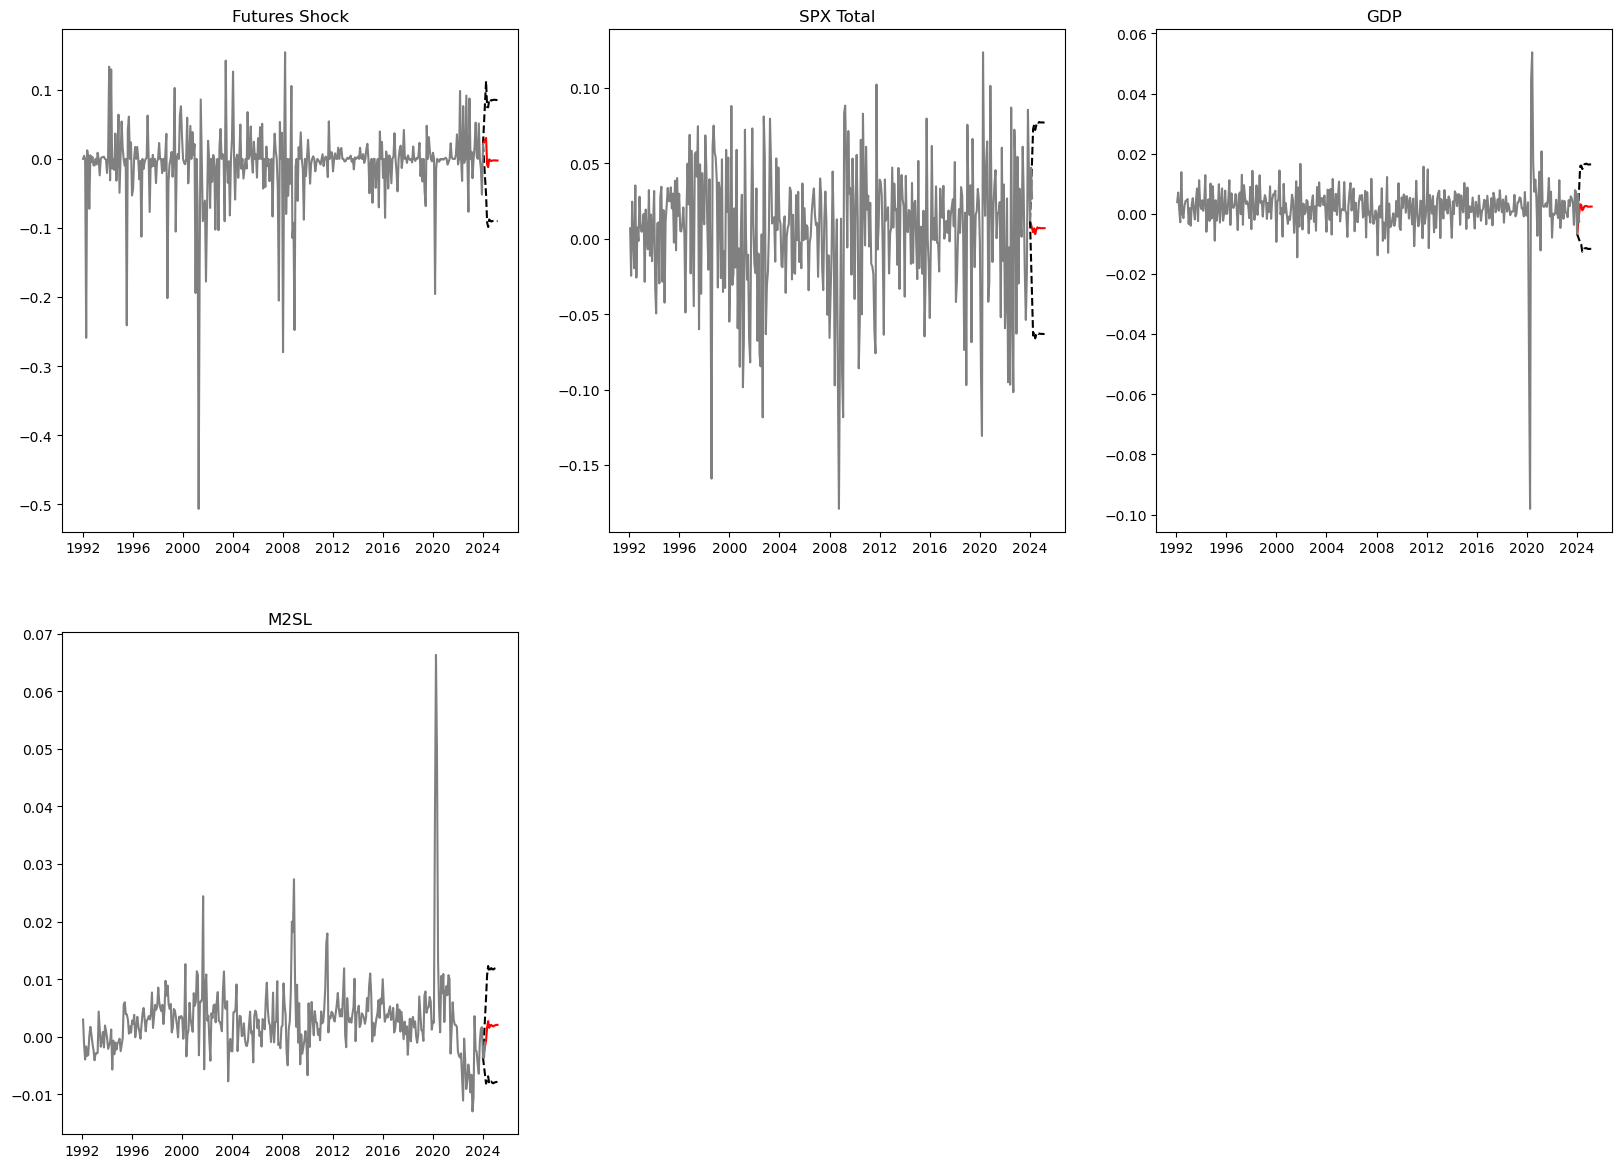

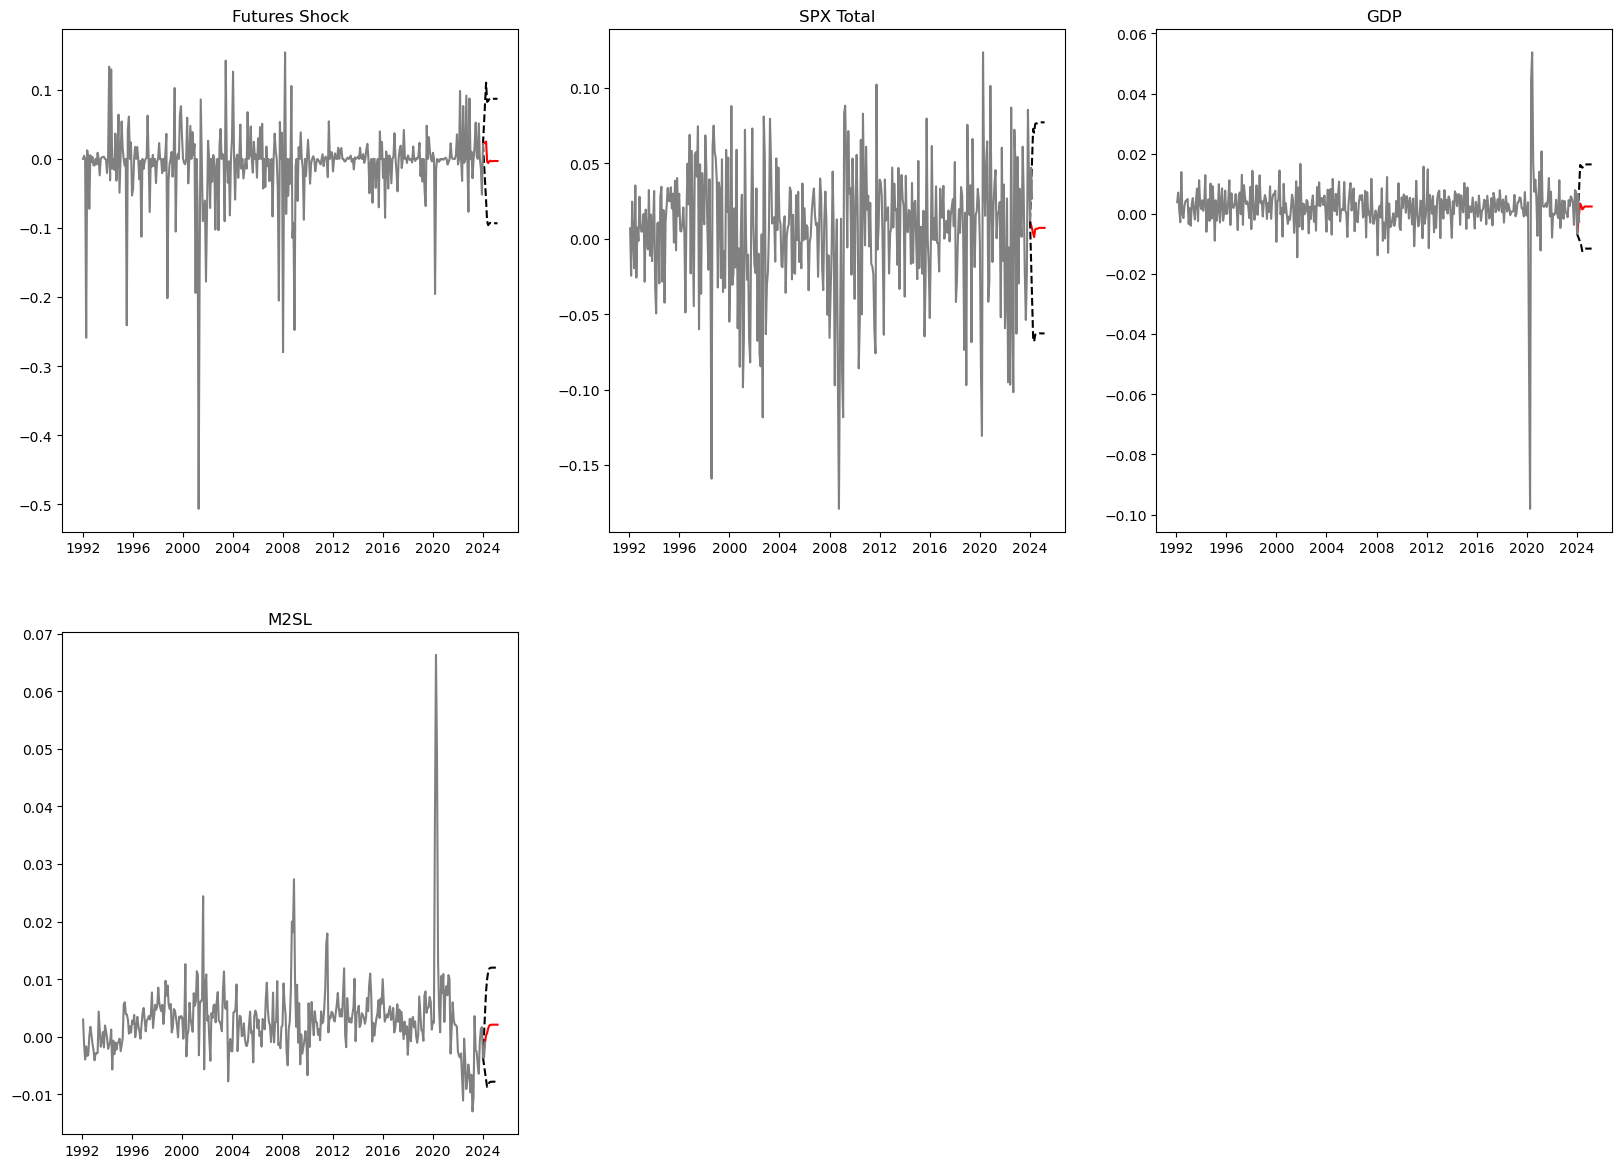

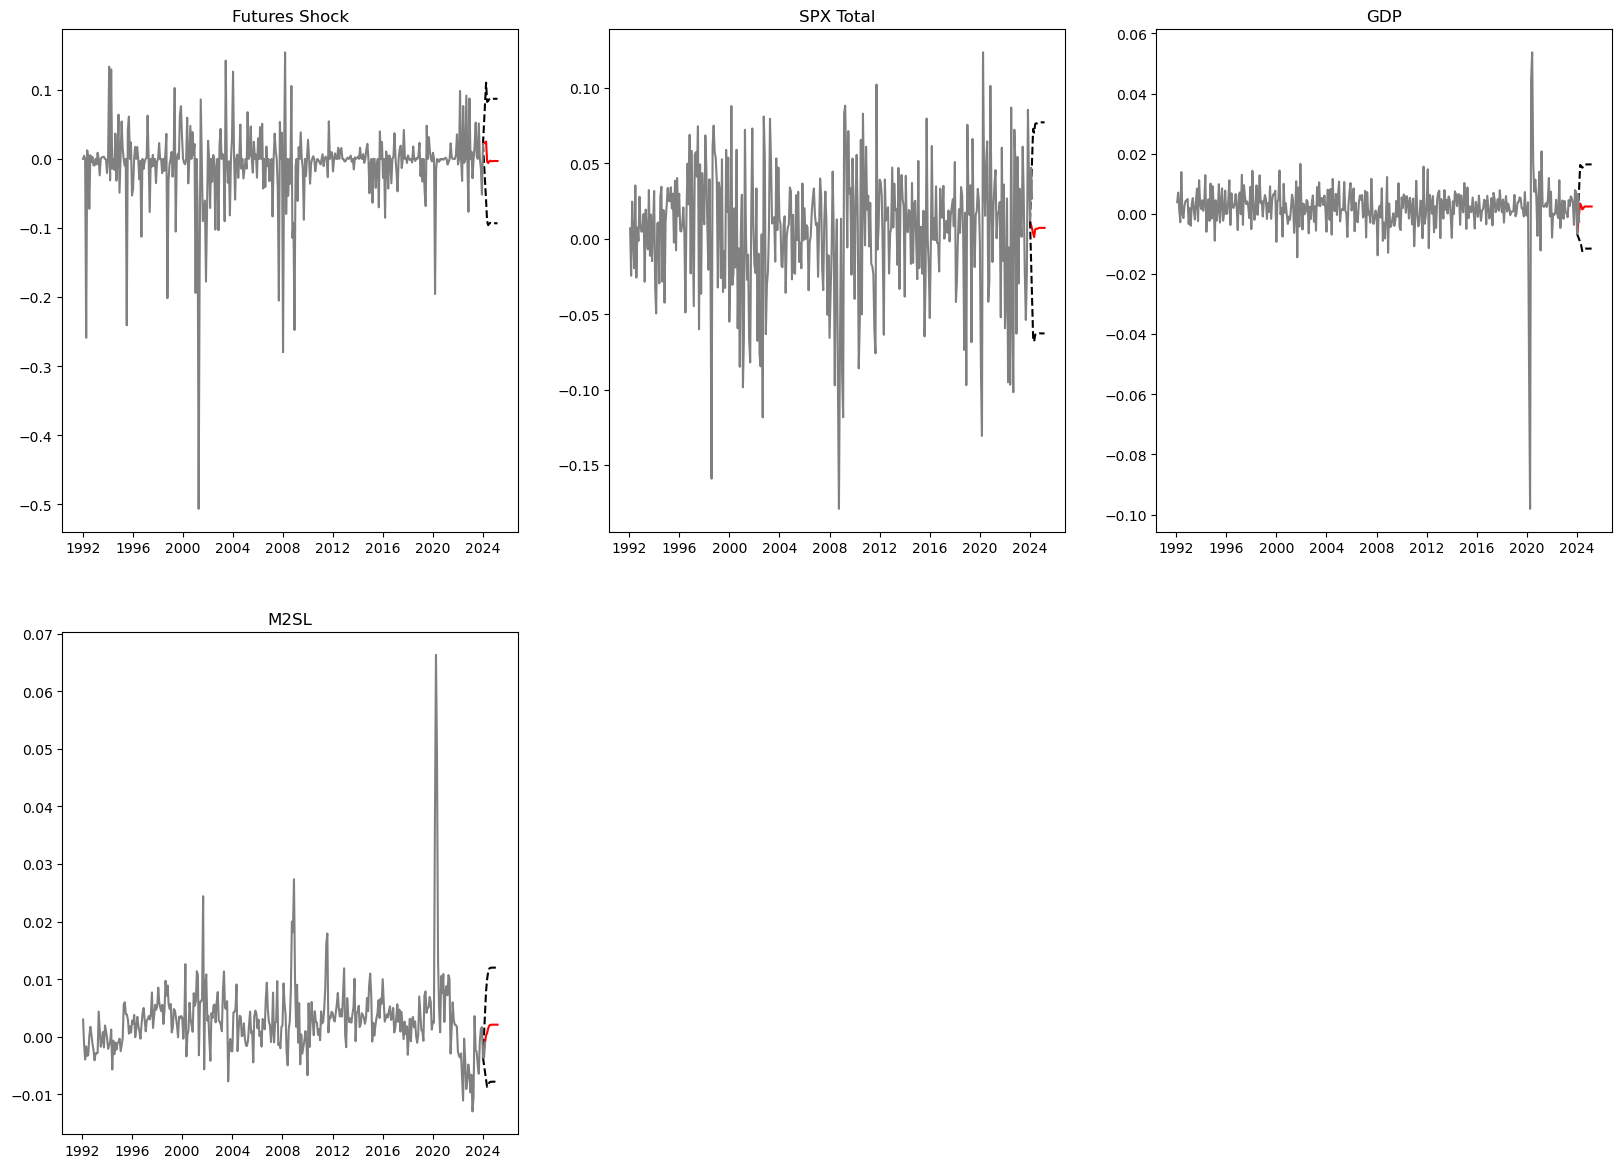

In [32]:
for industry in industry_names:    
    industry_df = industry_dataframes[industry_name]['industry_df']
    exogenous_df = industry_dataframes[industry_name]['exogenous_df']


    model = VECM(industry_df, k_ar_diff=lag_order_df[industry].iloc[0], coint_rank=coint_rank_df[industry].iloc[0], deterministic='ci', exog=exogenous_df)
    vecm_res = model.fit()
    
    # Forecast using the VECM model
    forecast, lower, upper = vecm_res.predict(steps=12, exog_fc=exog_forecast, alpha=0.1)
    forecast_df = pd.DataFrame(forecast, columns=industry_df.columns, index=exog_forecast.index)
    lower_ci = pd.DataFrame(lower, columns=industry_df.columns, index=exog_forecast.index)
    upper_ci = pd.DataFrame(upper, columns=industry_df.columns, index=exog_forecast.index)

    # Fix for last observation: use .iloc[-1] for single value
    last_obs = industry_df.iloc[-1]  # Get the last row as a Series
    
    forecast_df = pd.concat([last_obs.to_frame().T, forecast_df], ignore_index=False)
    lower_ci = pd.concat([last_obs.to_frame().T, lower_ci], ignore_index=False)
    upper_ci = pd.concat([last_obs.to_frame().T, upper_ci], ignore_index=False)

    plt.figure(figsize=(20, 30))
    for i, col in enumerate(forecast_df.columns):
        ax = plt.subplot(4, 3, i+1)
        ax.plot(upper_ci.index, upper_ci[col], color='black', linestyle='--')
        ax.plot(forecast_df.index, forecast_df[col], color='red')
        ax.plot(lower_ci.index, lower_ci[col], color='black', linestyle='--')
        ax.plot(treated_vars.index, treated_vars[col], color='gray')
        ax.set_title(col)
    
    #Store the forecasted values for each industry in a single dataframe
    if industry == industry_names[0]:
        all_industry_forecasts = forecast_df
        all_industry_lower_ci = lower_ci
        all_industry_upper_ci = upper_ci
    else:
        all_industry_forecasts = pd.concat([all_industry_forecasts, forecast_df], axis=1)
        all_industry_lower_ci = pd.concat([all_industry_lower_ci, lower_ci], axis=1)
        all_industry_upper_ci = pd.concat([all_industry_upper_ci, upper_ci], axis=1)

#remove duplicate columns of all_industry_forecasts
all_industry_forecasts = all_industry_forecasts.loc[:,~all_industry_forecasts.columns.duplicated()]
all_industry_lower_ci = all_industry_lower_ci.loc[:,~all_industry_lower_ci.columns.duplicated()]
all_industry_upper_ci = all_industry_upper_ci.loc[:,~all_industry_upper_ci.columns.duplicated()]


In [33]:
plot_industry_forecasts = pd.DataFrame()
plot_industry_upper = pd.DataFrame()
plot_industry_lower = pd.DataFrame()

for column in all_industry_forecasts.columns:
    # Get the last observation of every column from the data DataFrame
    last_observation = data[column].iloc[-1]

    plot_industry_forecasts[column] = np.exp(all_industry_forecasts[column].cumsum()) * last_observation
    plot_industry_upper[column] = np.exp(all_industry_upper_ci[column].cumsum()) * last_observation
    plot_industry_lower[column] = np.exp(all_industry_lower_ci[column].cumsum()) * last_observation


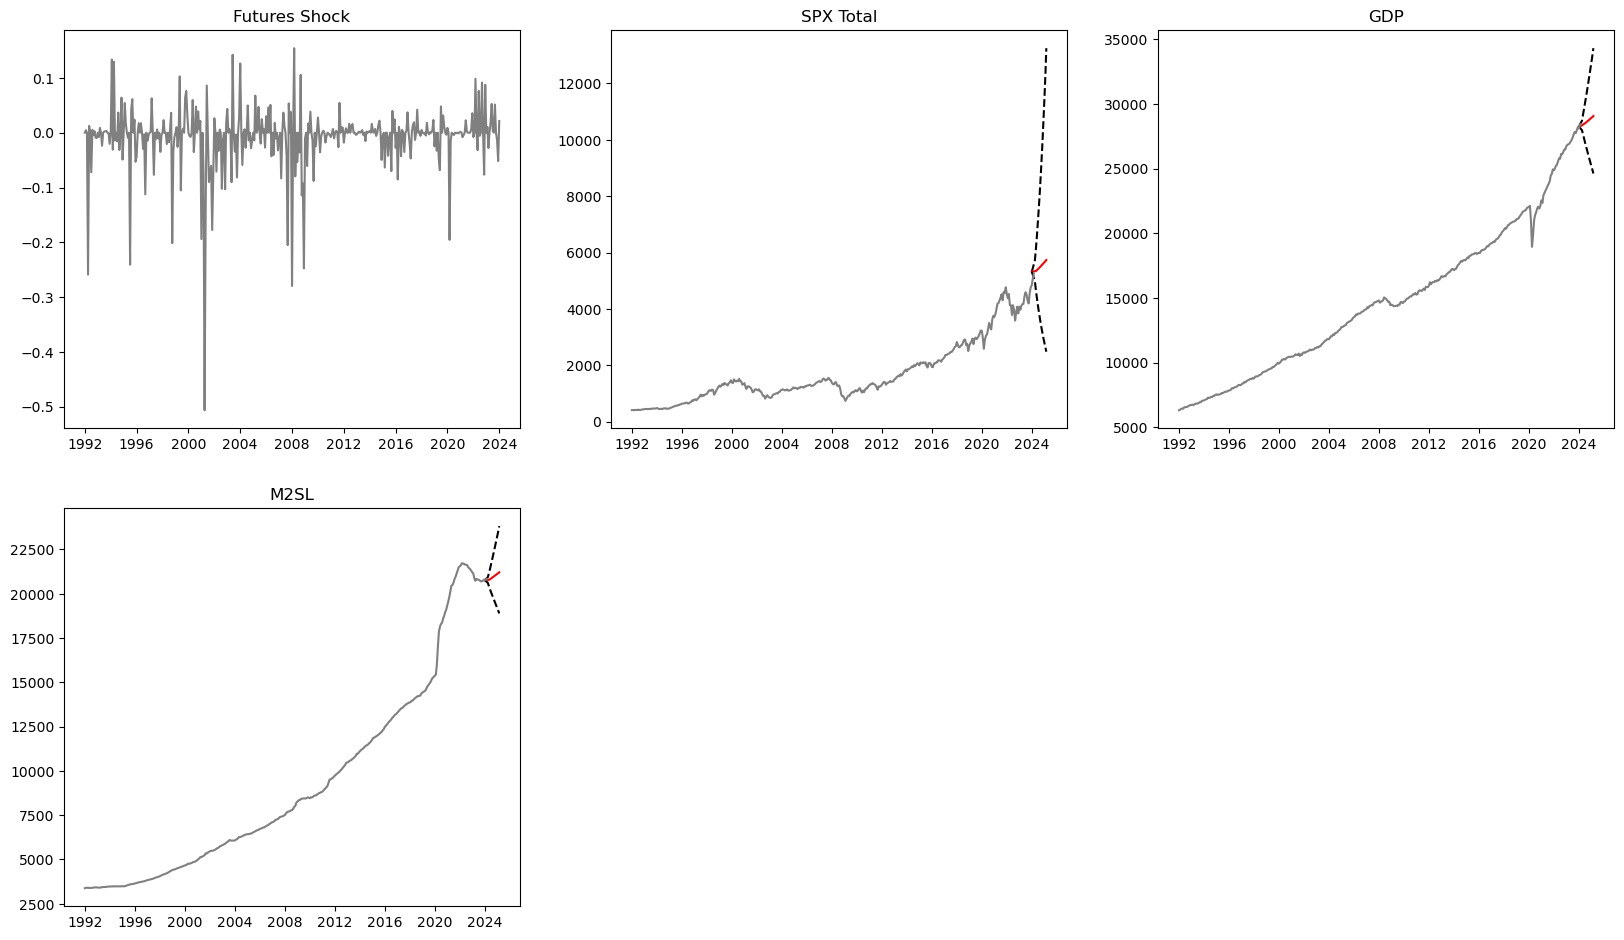

In [34]:
# Plot the forecast
plt.figure(figsize=(20, 30))
for i, col in enumerate(plot_industry_forecasts.columns):
    ax = plt.subplot(5, 3, i+1)
    ax.plot(plot_industry_upper.index, plot_industry_upper[col], color='black', linestyle='--')
    ax.plot(plot_industry_forecasts.index, plot_industry_forecasts[col], color='red')
    ax.plot(plot_industry_lower.index, plot_industry_lower[col], color='black', linestyle='--')
    ax.plot(treated_vars.index, data[col], color='gray')
    ax.set_title(col)


            Futures Shock  SPX Total       GDP      M2SL
Date                                                    
1992-02-01       0.004572   0.006960  0.003901  0.003010
1992-03-01       0.000000  -0.024466  0.007067 -0.001271
1992-04-01      -0.258935   0.024669  0.001374 -0.003932
1992-05-01       0.012382  -0.000126 -0.002797 -0.001654
1992-06-01       0.000000  -0.019500  0.013869 -0.003302
...                   ...        ...       ...       ...
2023-09-01       0.051324  -0.053777  0.003497 -0.006404
2023-10-01       0.000000  -0.022583 -0.003662 -0.000897
2023-11-01      -0.013891   0.085532  0.007875  0.001372
2023-12-01      -0.051664   0.042020  0.007313  0.001696
2024-01-01       0.021353   0.012003 -0.006675 -0.003567

[384 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Futures Shock  SPX Total       GDP      M2SL
Date                                                    
1992-02-01       0.004572   0.006960  0.003901  0.003010
1992-03-01       0.000000  -0.024466  0.007067 -0.001271
1992-04-01      -0.258935   0.024669  0.001374 -0.003932
1992-05-01       0.012382  -0.000126 -0.002797 -0.001654
1992-06-01       0.000000  -0.019500  0.013869 -0.003302
...                   ...        ...       ...       ...
2023-09-01       0.051324  -0.053777  0.003497 -0.006404
2023-10-01       0.000000  -0.022583 -0.003662 -0.000897
2023-11-01      -0.013891   0.085532  0.007875  0.001372
2023-12-01      -0.051664   0.042020  0.007313  0.001696
2024-01-01       0.021353   0.012003 -0.006675 -0.003567

[384 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Futures Shock  SPX Total       GDP      M2SL
Date                                                    
1992-02-01       0.004572   0.006960  0.003901  0.003010
1992-03-01       0.000000  -0.024466  0.007067 -0.001271
1992-04-01      -0.258935   0.024669  0.001374 -0.003932
1992-05-01       0.012382  -0.000126 -0.002797 -0.001654
1992-06-01       0.000000  -0.019500  0.013869 -0.003302
...                   ...        ...       ...       ...
2023-09-01       0.051324  -0.053777  0.003497 -0.006404
2023-10-01       0.000000  -0.022583 -0.003662 -0.000897
2023-11-01      -0.013891   0.085532  0.007875  0.001372
2023-12-01      -0.051664   0.042020  0.007313  0.001696
2024-01-01       0.021353   0.012003 -0.006675 -0.003567

[384 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Futures Shock  SPX Total       GDP      M2SL
Date                                                    
1992-02-01       0.004572   0.006960  0.003901  0.003010
1992-03-01       0.000000  -0.024466  0.007067 -0.001271
1992-04-01      -0.258935   0.024669  0.001374 -0.003932
1992-05-01       0.012382  -0.000126 -0.002797 -0.001654
1992-06-01       0.000000  -0.019500  0.013869 -0.003302
...                   ...        ...       ...       ...
2023-09-01       0.051324  -0.053777  0.003497 -0.006404
2023-10-01       0.000000  -0.022583 -0.003662 -0.000897
2023-11-01      -0.013891   0.085532  0.007875  0.001372
2023-12-01      -0.051664   0.042020  0.007313  0.001696
2024-01-01       0.021353   0.012003 -0.006675 -0.003567

[384 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Futures Shock  SPX Total       GDP      M2SL
Date                                                    
1992-02-01       0.004572   0.006960  0.003901  0.003010
1992-03-01       0.000000  -0.024466  0.007067 -0.001271
1992-04-01      -0.258935   0.024669  0.001374 -0.003932
1992-05-01       0.012382  -0.000126 -0.002797 -0.001654
1992-06-01       0.000000  -0.019500  0.013869 -0.003302
...                   ...        ...       ...       ...
2023-09-01       0.051324  -0.053777  0.003497 -0.006404
2023-10-01       0.000000  -0.022583 -0.003662 -0.000897
2023-11-01      -0.013891   0.085532  0.007875  0.001372
2023-12-01      -0.051664   0.042020  0.007313  0.001696
2024-01-01       0.021353   0.012003 -0.006675 -0.003567

[384 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Futures Shock  SPX Total       GDP      M2SL
Date                                                    
1992-02-01       0.004572   0.006960  0.003901  0.003010
1992-03-01       0.000000  -0.024466  0.007067 -0.001271
1992-04-01      -0.258935   0.024669  0.001374 -0.003932
1992-05-01       0.012382  -0.000126 -0.002797 -0.001654
1992-06-01       0.000000  -0.019500  0.013869 -0.003302
...                   ...        ...       ...       ...
2023-09-01       0.051324  -0.053777  0.003497 -0.006404
2023-10-01       0.000000  -0.022583 -0.003662 -0.000897
2023-11-01      -0.013891   0.085532  0.007875  0.001372
2023-12-01      -0.051664   0.042020  0.007313  0.001696
2024-01-01       0.021353   0.012003 -0.006675 -0.003567

[384 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Futures Shock  SPX Total       GDP      M2SL
Date                                                    
1992-02-01       0.004572   0.006960  0.003901  0.003010
1992-03-01       0.000000  -0.024466  0.007067 -0.001271
1992-04-01      -0.258935   0.024669  0.001374 -0.003932
1992-05-01       0.012382  -0.000126 -0.002797 -0.001654
1992-06-01       0.000000  -0.019500  0.013869 -0.003302
...                   ...        ...       ...       ...
2023-09-01       0.051324  -0.053777  0.003497 -0.006404
2023-10-01       0.000000  -0.022583 -0.003662 -0.000897
2023-11-01      -0.013891   0.085532  0.007875  0.001372
2023-12-01      -0.051664   0.042020  0.007313  0.001696
2024-01-01       0.021353   0.012003 -0.006675 -0.003567

[384 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Futures Shock  SPX Total       GDP      M2SL
Date                                                    
1992-02-01       0.004572   0.006960  0.003901  0.003010
1992-03-01       0.000000  -0.024466  0.007067 -0.001271
1992-04-01      -0.258935   0.024669  0.001374 -0.003932
1992-05-01       0.012382  -0.000126 -0.002797 -0.001654
1992-06-01       0.000000  -0.019500  0.013869 -0.003302
...                   ...        ...       ...       ...
2023-09-01       0.051324  -0.053777  0.003497 -0.006404
2023-10-01       0.000000  -0.022583 -0.003662 -0.000897
2023-11-01      -0.013891   0.085532  0.007875  0.001372
2023-12-01      -0.051664   0.042020  0.007313  0.001696
2024-01-01       0.021353   0.012003 -0.006675 -0.003567

[384 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Futures Shock  SPX Total       GDP      M2SL
Date                                                    
1992-02-01       0.004572   0.006960  0.003901  0.003010
1992-03-01       0.000000  -0.024466  0.007067 -0.001271
1992-04-01      -0.258935   0.024669  0.001374 -0.003932
1992-05-01       0.012382  -0.000126 -0.002797 -0.001654
1992-06-01       0.000000  -0.019500  0.013869 -0.003302
...                   ...        ...       ...       ...
2023-09-01       0.051324  -0.053777  0.003497 -0.006404
2023-10-01       0.000000  -0.022583 -0.003662 -0.000897
2023-11-01      -0.013891   0.085532  0.007875  0.001372
2023-12-01      -0.051664   0.042020  0.007313  0.001696
2024-01-01       0.021353   0.012003 -0.006675 -0.003567

[384 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Futures Shock  SPX Total       GDP      M2SL
Date                                                    
1992-02-01       0.004572   0.006960  0.003901  0.003010
1992-03-01       0.000000  -0.024466  0.007067 -0.001271
1992-04-01      -0.258935   0.024669  0.001374 -0.003932
1992-05-01       0.012382  -0.000126 -0.002797 -0.001654
1992-06-01       0.000000  -0.019500  0.013869 -0.003302
...                   ...        ...       ...       ...
2023-09-01       0.051324  -0.053777  0.003497 -0.006404
2023-10-01       0.000000  -0.022583 -0.003662 -0.000897
2023-11-01      -0.013891   0.085532  0.007875  0.001372
2023-12-01      -0.051664   0.042020  0.007313  0.001696
2024-01-01       0.021353   0.012003 -0.006675 -0.003567

[384 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Futures Shock  SPX Total       GDP      M2SL
Date                                                    
1992-02-01       0.004572   0.006960  0.003901  0.003010
1992-03-01       0.000000  -0.024466  0.007067 -0.001271
1992-04-01      -0.258935   0.024669  0.001374 -0.003932
1992-05-01       0.012382  -0.000126 -0.002797 -0.001654
1992-06-01       0.000000  -0.019500  0.013869 -0.003302
...                   ...        ...       ...       ...
2023-09-01       0.051324  -0.053777  0.003497 -0.006404
2023-10-01       0.000000  -0.022583 -0.003662 -0.000897
2023-11-01      -0.013891   0.085532  0.007875  0.001372
2023-12-01      -0.051664   0.042020  0.007313  0.001696
2024-01-01       0.021353   0.012003 -0.006675 -0.003567

[384 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Futures Shock  SPX Total       GDP      M2SL
Date                                                    
1992-02-01       0.004572   0.006960  0.003901  0.003010
1992-03-01       0.000000  -0.024466  0.007067 -0.001271
1992-04-01      -0.258935   0.024669  0.001374 -0.003932
1992-05-01       0.012382  -0.000126 -0.002797 -0.001654
1992-06-01       0.000000  -0.019500  0.013869 -0.003302
...                   ...        ...       ...       ...
2023-09-01       0.051324  -0.053777  0.003497 -0.006404
2023-10-01       0.000000  -0.022583 -0.003662 -0.000897
2023-11-01      -0.013891   0.085532  0.007875  0.001372
2023-12-01      -0.051664   0.042020  0.007313  0.001696
2024-01-01       0.021353   0.012003 -0.006675 -0.003567

[384 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Error in callback <function _draw_all_if_interactive at 0x121d0f240> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

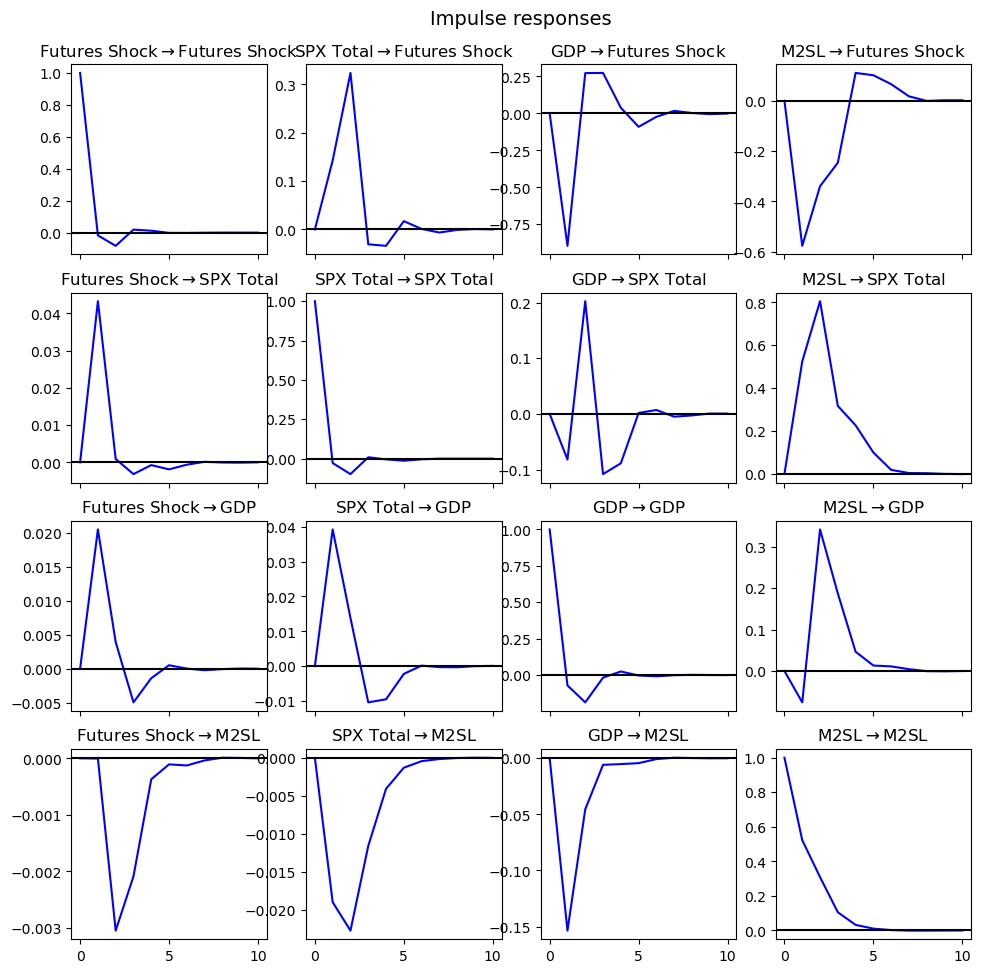

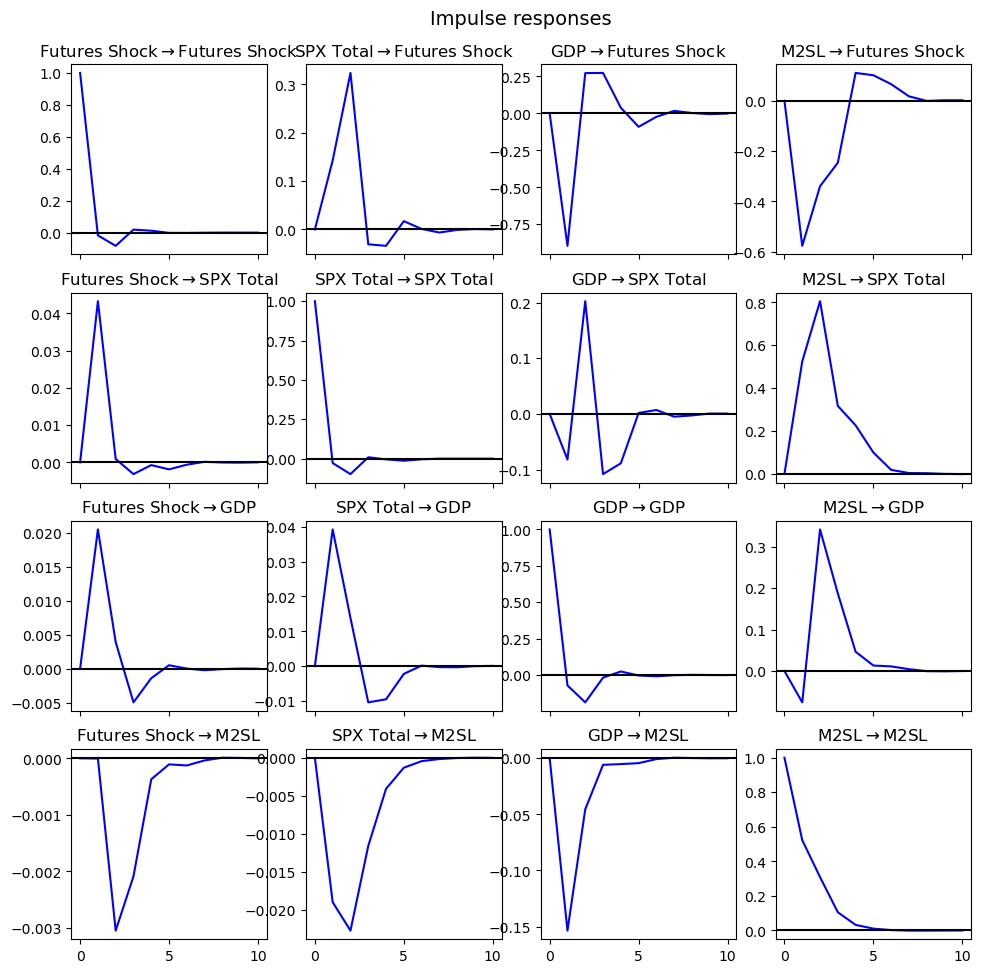

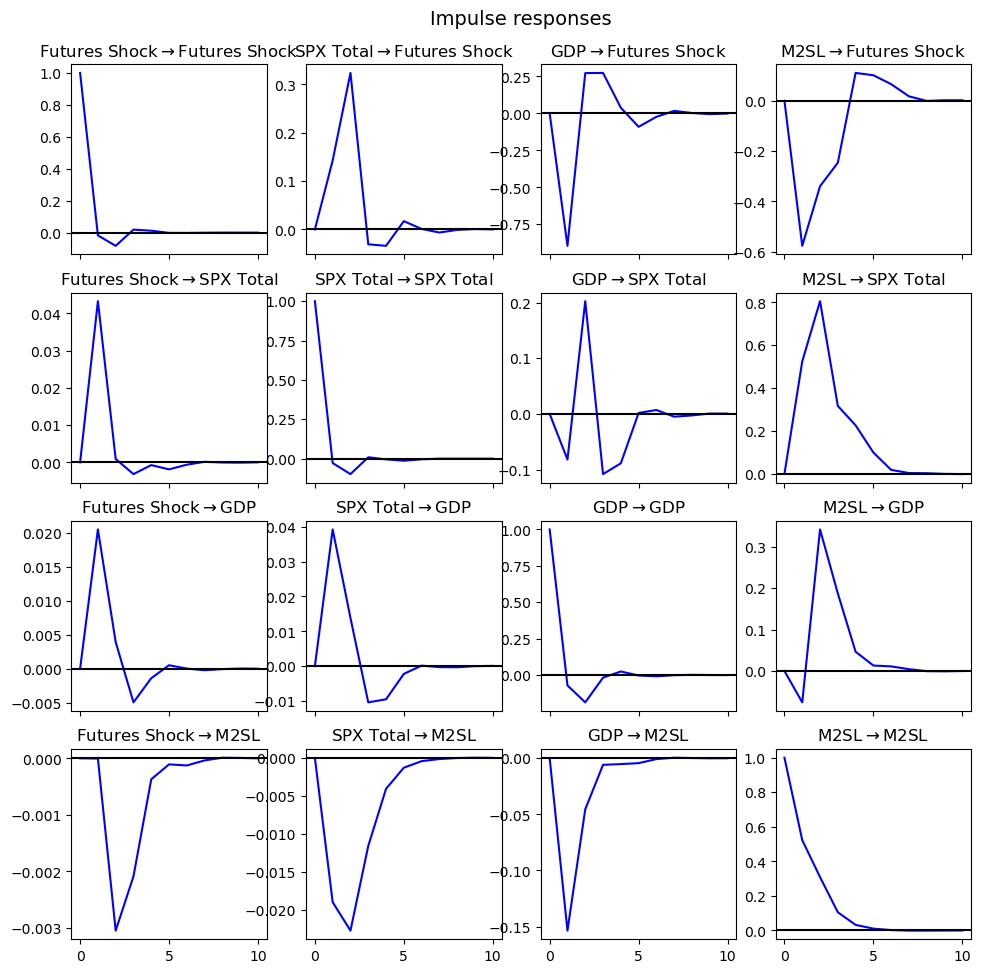

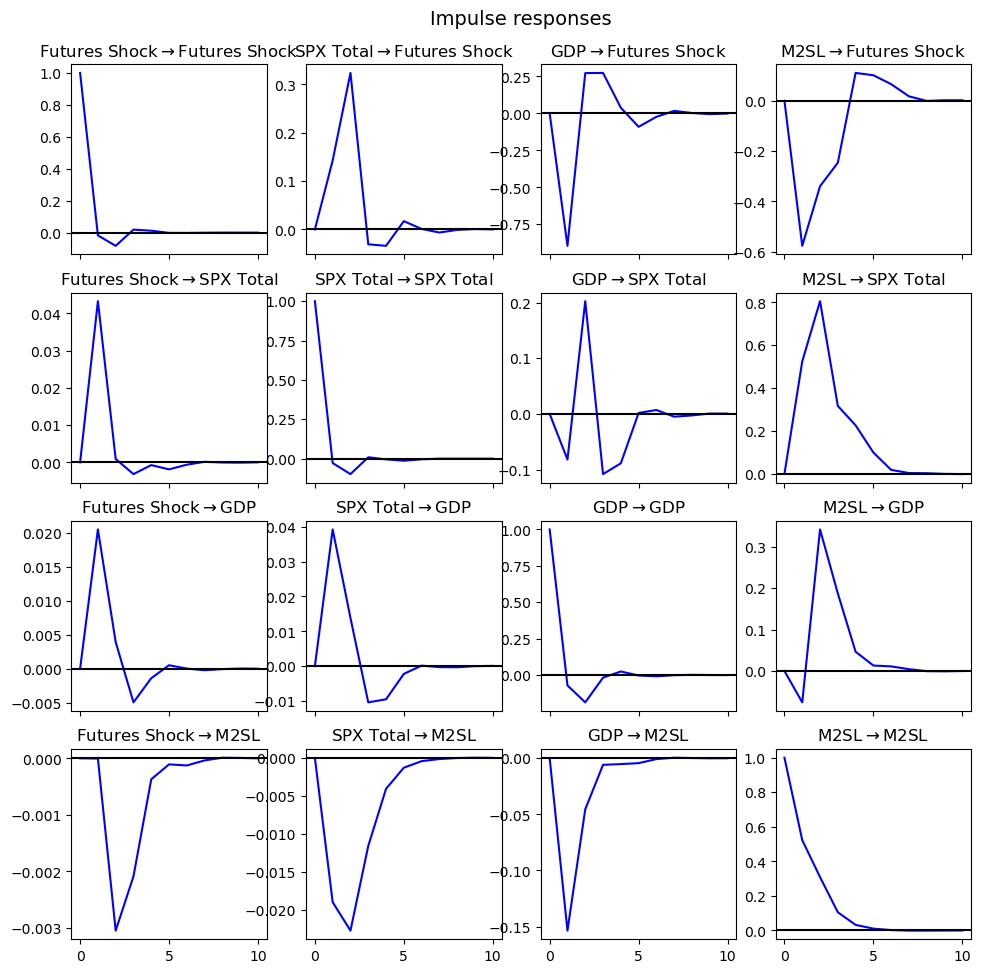

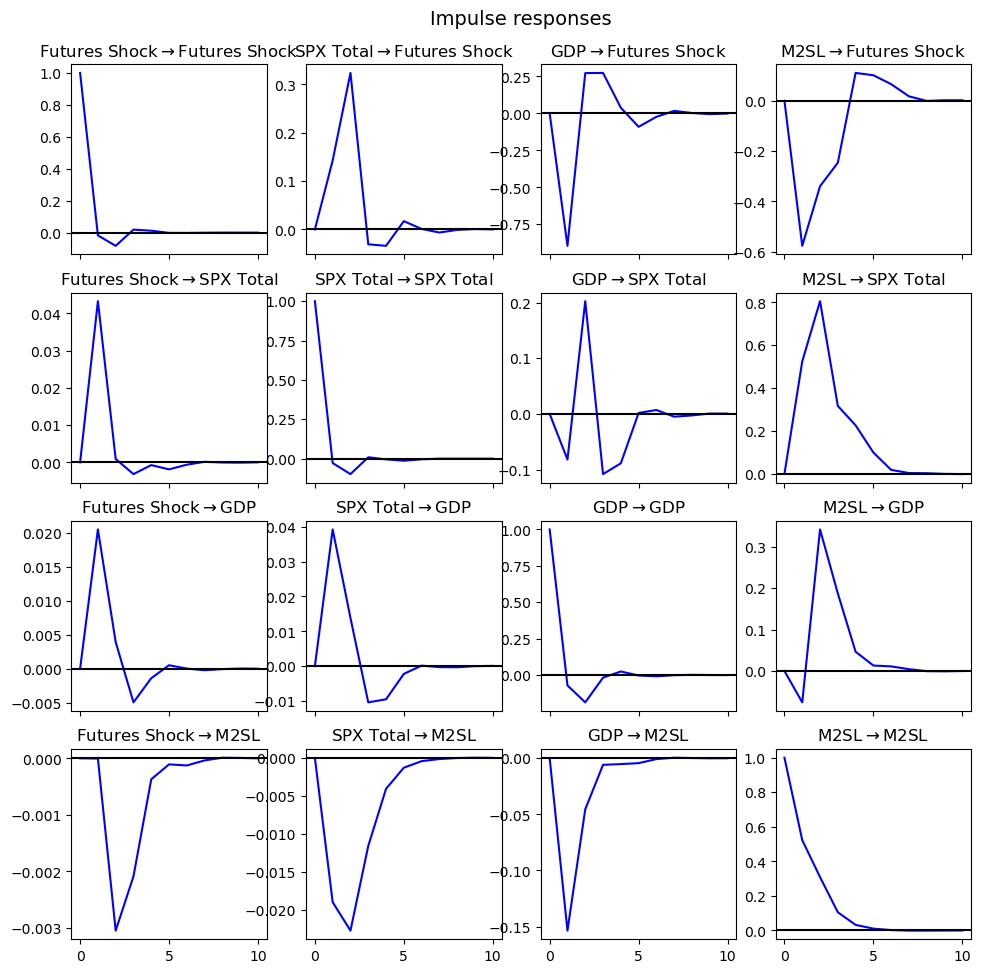

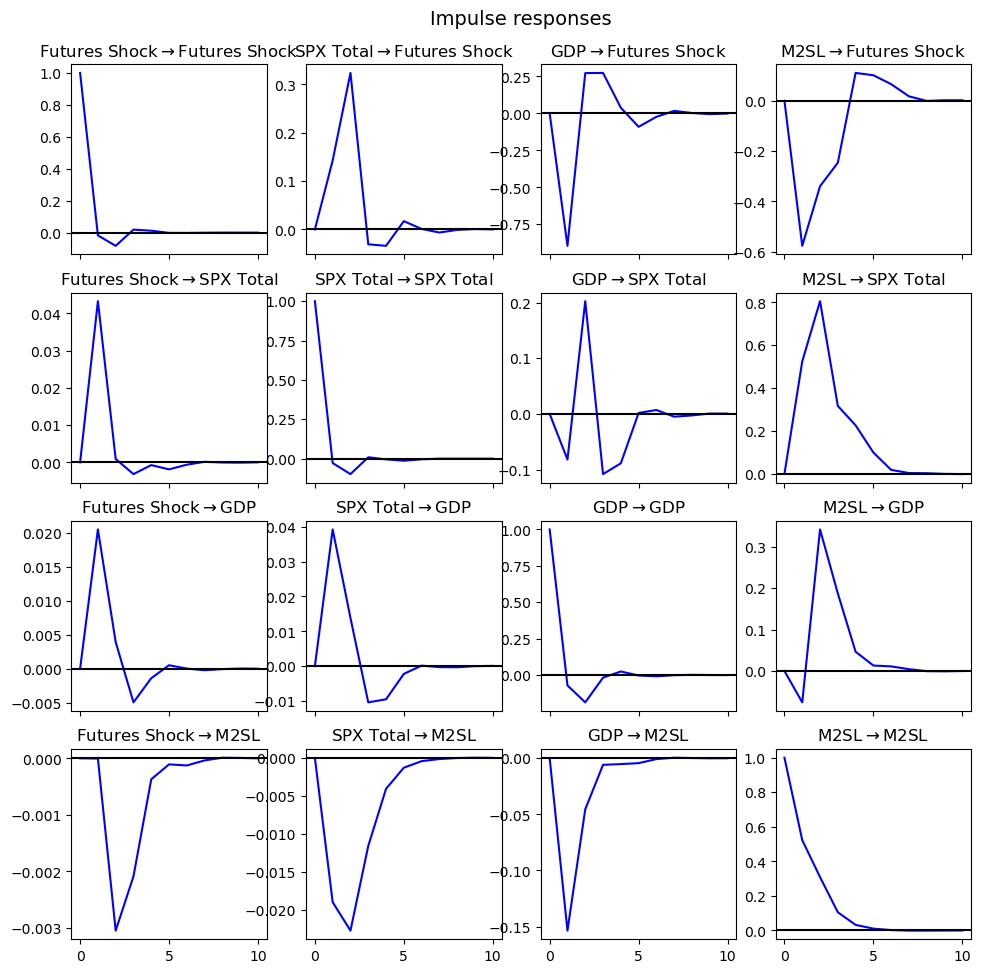

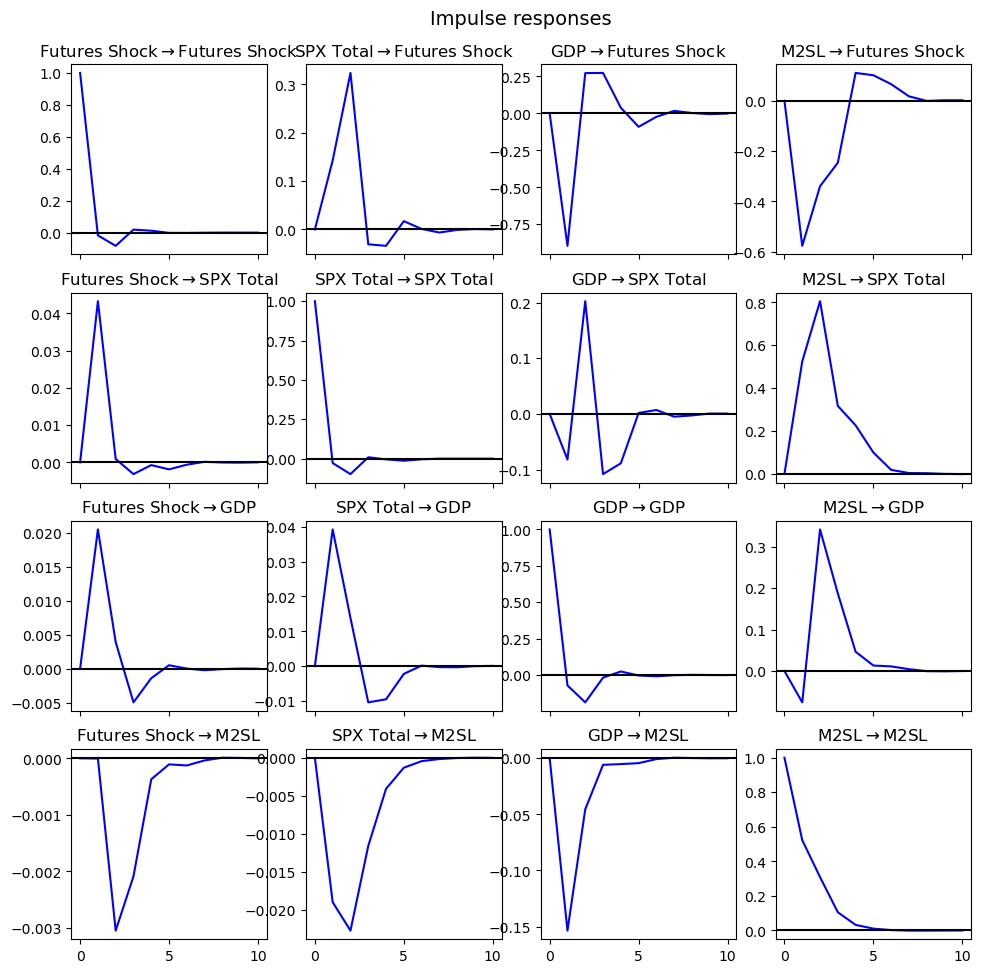

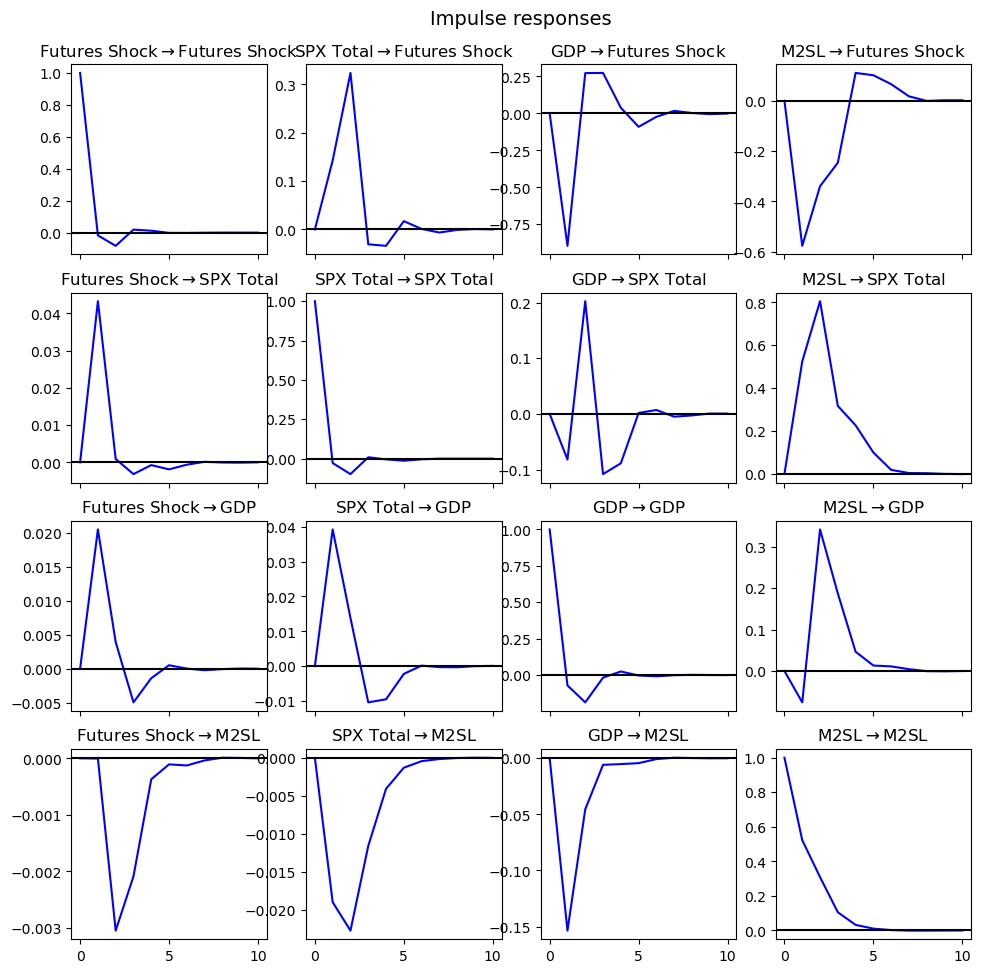

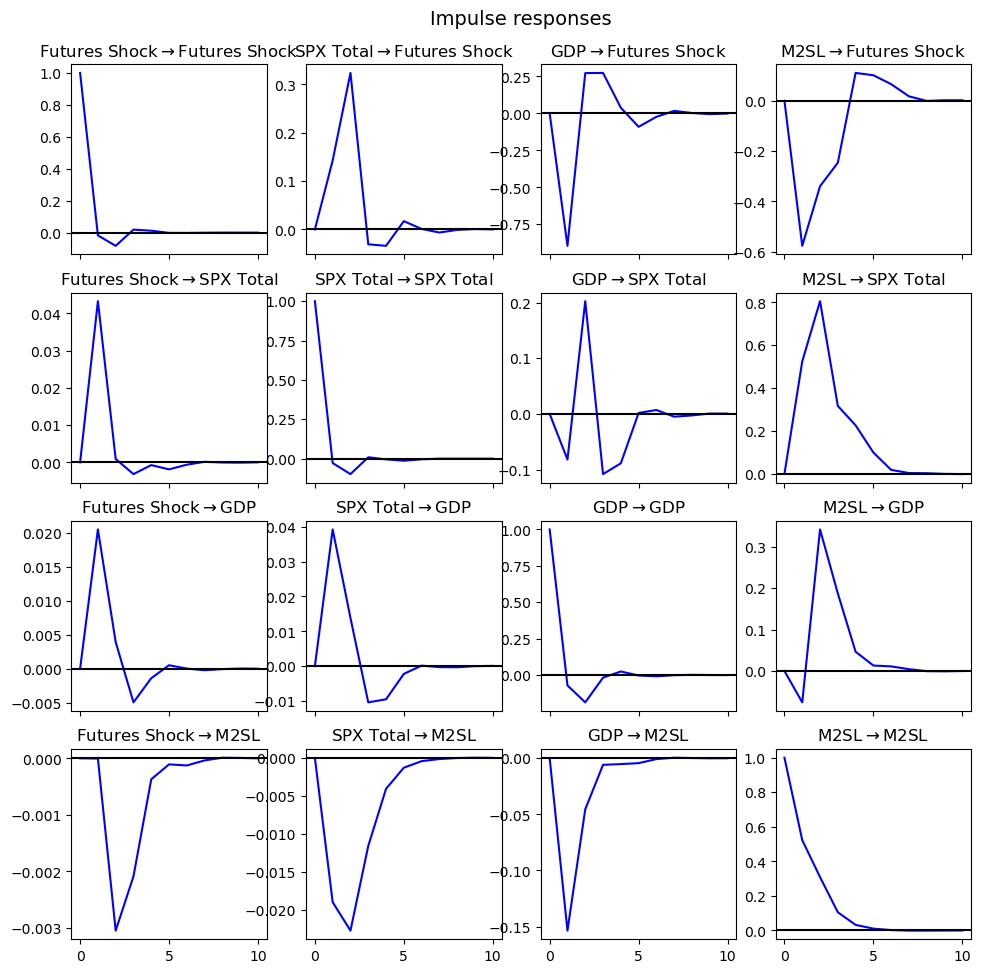

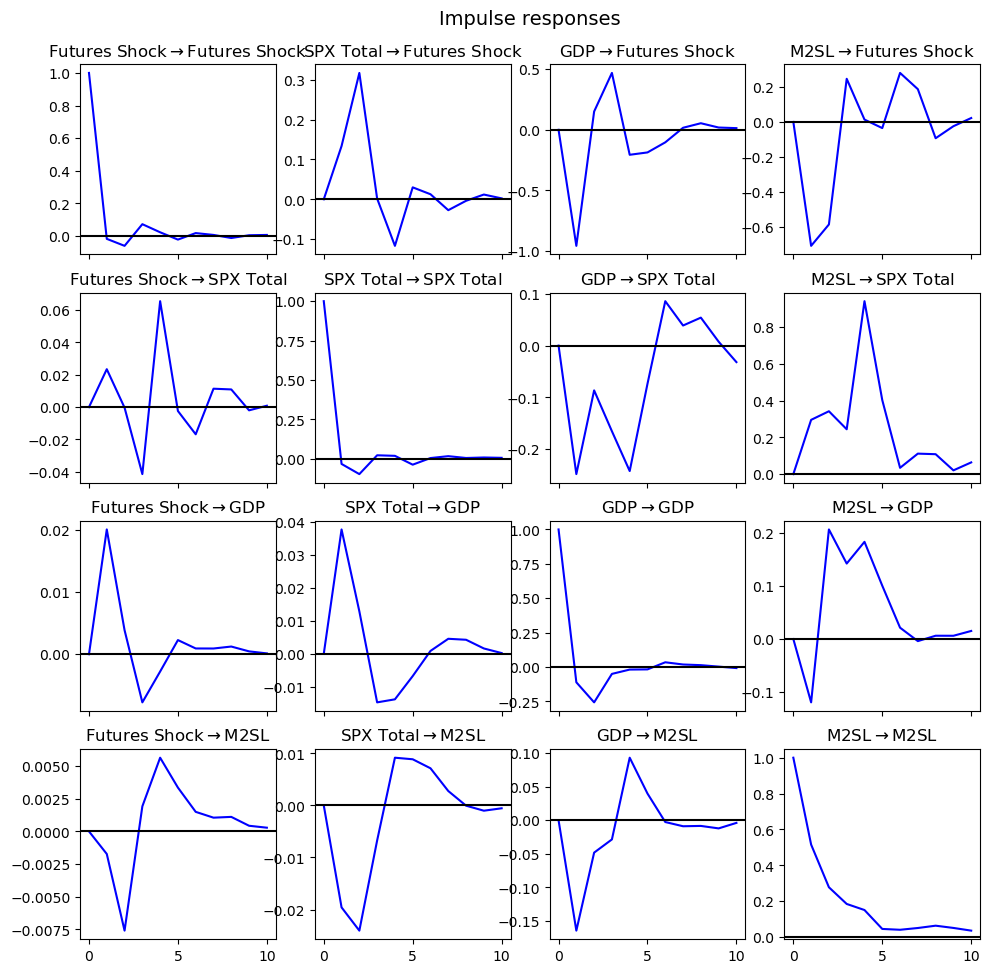

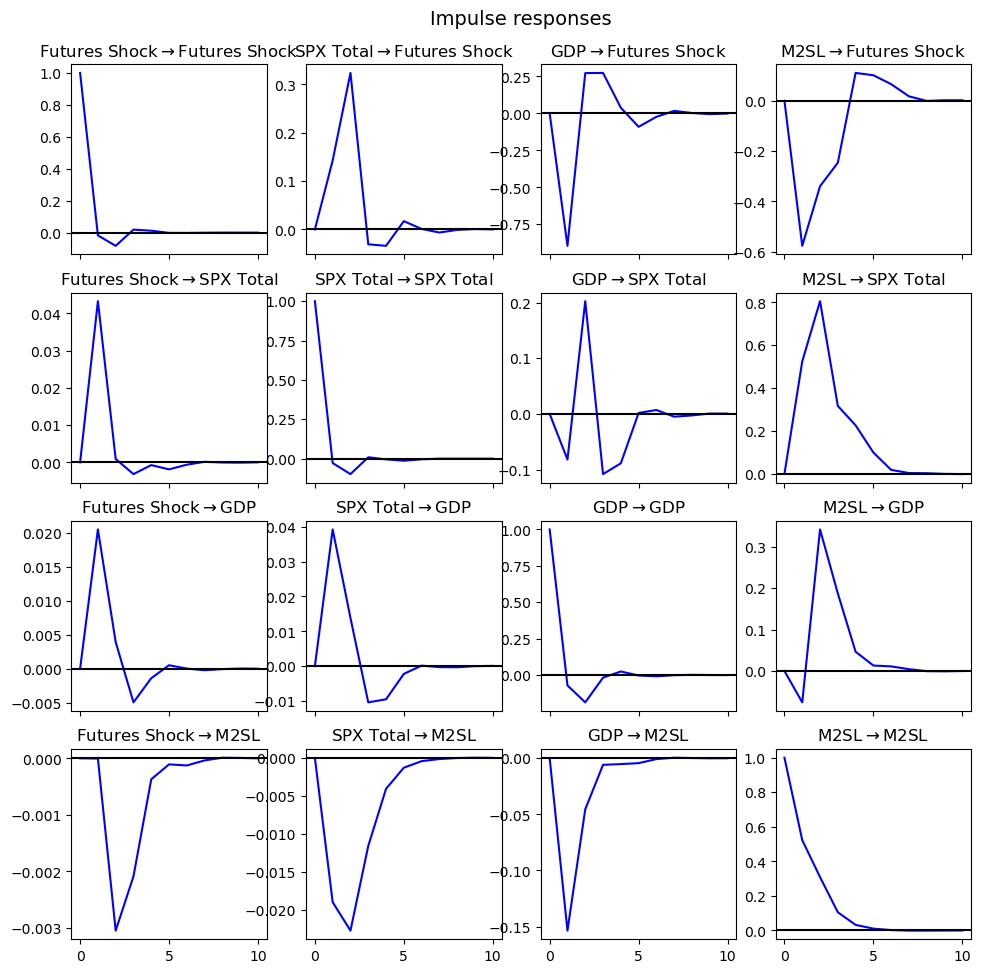

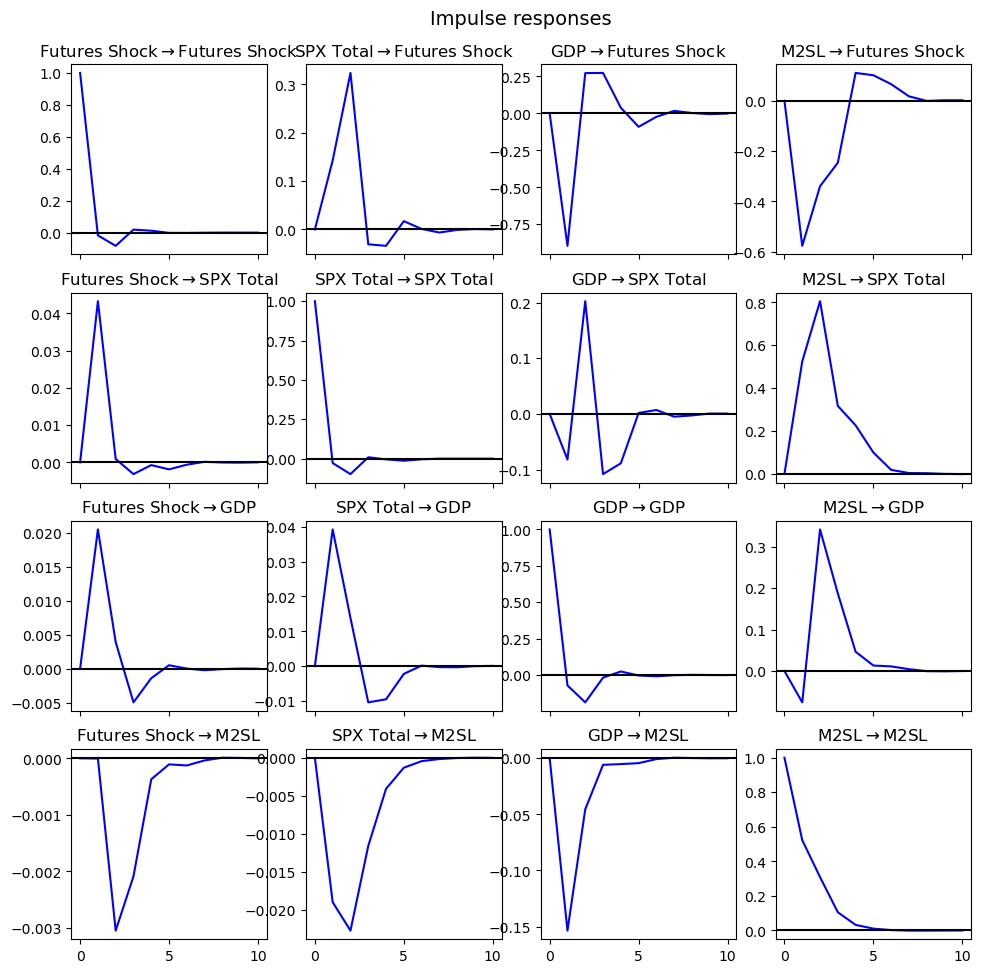

In [35]:
for industry in industry_names:
    industry_df = industry_dataframes[industry_name]['industry_df'].dropna()
    exogenous_df = industry_dataframes[industry_name]['exogenous_df'].dropna()
    
    #make sure both dfs have the same index
    common_index = industry_df.index.intersection(exogenous_df.index)
    industry_df = industry_df.loc[common_index]
    exogenous_df = exogenous_df.loc[common_index]
    
    model = VECM(industry_df, k_ar_diff=lag_order_df[industry].iloc[0], coint_rank=coint_rank_df[industry].iloc[0], deterministic='ci', exog=exogenous_df)
    vecm_res = model.fit()
    ir = vecm_res.irf(periods=10)
    ir.plot(plot_stderr=False)

In [ ]:
for industry in industry_names:
    industry_df = industry_dataframes[industry]['industry_df']
    exogenous_df = industry_dataframes[industry]['exogenous_df']
        
    model = VECM(industry_df, k_ar_diff=lag_order_df[industry].iloc[1], coint_rank=coint_rank_df[industry].iloc[0], deterministic='ci', exog=exogenous_df)
    vecm_res = model.fit()
    norm_test = vecm_res.test_normality()
    print(norm_test.summary())